# Contents
* [Introduction](#Introduction)
* [Imports and configuration](#Imports-and-configuration)
* [Data loading](#Data-loading)
* [Importances](#Importances)
* [Discussion](#Discussion)

# Introduction

Earlier, the results of feature engineering were assessed with cross validation. This notebook extracts selected FRILL-based features from the whole dataset for prototyping.

We ran this notebook earlier with QuantileTransformed data. This time we're trying them unscaled. The two algos of interest, GNB and RF, don't need too much scaling anyways. However, the feature importances may be skewed. By using a "power" transformer, we may be erasing relationships between variables. Maybe we should've tried StandardScaler too, but we're wrapping this up now.

In [1]:
from time import time

notebook_begin_time = time()

# set random seeds

from os import environ
from random import seed as random_seed
from numpy.random import seed as np_seed
from tensorflow.random import set_seed


def reset_seeds(seed: int) -> None:
    """Utility function for resetting random seeds"""
    environ["PYTHONHASHSEED"] = str(seed)
    random_seed(seed)
    np_seed(seed)
    set_seed(seed)


reset_seeds(SEED := 2021)
del environ
del random_seed
del np_seed
del set_seed
del reset_seeds

In [2]:
# extensions
%load_ext autotime
%load_ext lab_black
%load_ext nb_black

In [3]:
# core
import numpy as np
import pandas as pd

# utility
from copy import deepcopy
from gc import collect as gc_collect
from tqdm.notebook import tqdm

# faster sklearn
from sklearnex import patch_sklearn

patch_sklearn()
del patch_sklearn

# typing
from sklearn.base import BaseEstimator
from typing import Callable, Dict

# feature assessment
from sklearn.ensemble import (
    AdaBoostClassifier,
    BaggingClassifier,
    ExtraTreesClassifier,
    RandomForestClassifier,
)
from sklearn.feature_selection import mutual_info_classif, SelectFromModel, SelectKBest
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

# metrics
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%matplotlib widget  # for interactive plots

sns.set_context("notebook")

# full display of rows and columns
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", None)

# display outputs w/o print calls
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
del InteractiveShell

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


time: 2.79 s


UsageError: unrecognized arguments: # for interactive plots


In [4]:
# Location of FRILL .feather files
FRILL_FEATHERS_FOLDER = "../1.0-mic-extract_FRILL_embeddings"

# Location of pre-final features
FEATURES_FOLDER = "."

# Location where this notebook will output
DATA_OUT_FOLDER = "."

_ = gc_collect()

time: 119 ms


# Data loading

In [5]:
def load_labels() -> pd.DataFrame:
    """Load just the labels"""
    keep_columns = [
        "id",
        "source",
        "speaker_id",
        "speaker_gender",
        "emo",
        "valence",
        "lang1",
    ]
    labels = pd.concat(
        (
            pd.read_feather(
                f"{FRILL_FEATHERS_FOLDER}/dev_labels.feather", columns=keep_columns
            ),
            pd.read_feather(
                f"{FRILL_FEATHERS_FOLDER}/nondev_labels.feather", columns=keep_columns
            ),
        )
    ).set_index("id")
    return labels


def load_data(unscaled=False) -> pd.DataFrame:
    """Loads the FRILL data"""
    if unscaled:
        df = pd.read_feather(
            f"{FEATURES_FOLDER}/unscaled_features_ready_for_selection.feather"
        ).set_index("id")
    else:
        df = pd.read_feather(
            f"{FEATURES_FOLDER}/features_ready_for_selection.feather"
        ).set_index("id")
    df.columns = df.columns.astype(str)
    # df.columns = df.columns.str.replace(r"+", r"-", regex=True)
    return df


data = load_data(unscaled=True)
labels = load_labels()
y_true = labels.valence

assert all(data.index == labels.index)
_ = gc_collect()

time: 278 ms


In [6]:
data.info()
labels.info()

<class 'pandas.core.frame.DataFrame'>
UInt64Index: 86752 entries, 0 to 87363
Columns: 118 entries, theta_LDA1+LDA2 to LDA-ocSVM_poly6_pos
dtypes: float64(118)
memory usage: 78.8 MB
<class 'pandas.core.frame.DataFrame'>
UInt64Index: 86752 entries, 0 to 87363
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   source          86752 non-null  category
 1   speaker_id      86752 non-null  category
 2   speaker_gender  86752 non-null  category
 3   emo             86752 non-null  category
 4   valence         86752 non-null  int8    
 5   lang1           86752 non-null  category
dtypes: category(5), int8(1)
memory usage: 1.3 MB
time: 26.5 ms


In [7]:
def plot_importances(
    fitted_tree: BaseEstimator, fig_height: int = 100, title: str = ""
) -> None:
    """Plot feature importances"""
    data = pd.Series(
        fitted_tree.feature_importances_, index=fitted_tree.feature_names_in_
    ).sort_values(ascending=False)
    plt.figure(figsize=(10, fig_height))
    sns.barplot(
        x=data.values,
        y=data.index,
        seed=SEED,
        palette="colorblind",
        linewidth=0,
    )
    sns.despine(top=True, right=True)
    if title:
        plt.suptitle(title)
    plt.tight_layout()
    plt.show()


def score_model(
    fitted_model: BaseEstimator, model_name: str = "", data: pd.DataFrame = data
) -> Dict[str, float]:
    """score a model with accuracy, auroc, and log losss"""
    scores = {}
    scores["accuracy"] = accuracy_score(y_true, fitted_model.predict(data))
    scores["roc_auc_ovo"] = roc_auc_score(
        y_true, _ := fitted_model.predict_proba(data), multi_class="ovo"
    )
    scores["log_loss"] = log_loss(y_true, _)
    print(model_name)
    for score in scores:
        print(f"{score}: {scores[score]:.4f}")
    return scores


def fit_trees(data: pd.DataFrame, y_true: pd.Series) -> Dict[str, BaseEstimator]:
    "fit selected tree ensembles"
    common_params = {
        "criterion": "entropy",
        "max_features": "sqrt",
        "random_state": SEED,
    }
    common_params2 = {
        **common_params,
        "max_depth": 15,
        "bootstrap": True,
        "oob_score": True,
        "n_jobs": -1,
        "class_weight": "balanced_subsample",
    }
    trees = {
        "AdaBoost": lambda: AdaBoostClassifier(
            base_estimator=DecisionTreeClassifier(
                splitter="random", max_depth=1, **common_params
            ),
            random_state=SEED,
        ),
        "ExtraTrees": lambda: ExtraTreesClassifier(**common_params2),
        "RandomForest": lambda: RandomForestClassifier(**common_params2),
    }
    return {k: v().fit(data, y_true) for k, v in trees.items()}


_ = gc_collect()

time: 129 ms


# Importances

Fit before

In [8]:
make_gnb: Callable = lambda: BaggingClassifier(
    base_estimator=GaussianNB(),
    n_estimators=50,
    oob_score=True,
    n_jobs=-1,
    random_state=SEED,
)
fitted_models = {
    **(fitted_trees := fit_trees(data, y_true)),
    "GaussianNB": make_gnb().fit(data, y_true),
}

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


time: 1min 1s


Scores before

In [9]:
scores_before = {
    fitted_model: score_model(fitted_models[fitted_model], fitted_model)
    for fitted_model in fitted_models
}

AdaBoost
accuracy: 0.8072
roc_auc_ovo: 0.9061
log_loss: 1.0102
ExtraTrees
accuracy: 0.9250
roc_auc_ovo: 0.9921
log_loss: 0.2417


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


RandomForest
accuracy: 0.9874
roc_auc_ovo: 0.9997
log_loss: 0.0855
GaussianNB
accuracy: 0.6972
roc_auc_ovo: 0.8823
log_loss: 1.6493
time: 20.9 s


out of bag scores (n/a for AdaBoost)

In [10]:
print("GaussianNB:", oob_gnb := fitted_models["GaussianNB"].oob_score_)
print("Extra Trees:", oob_extra := fitted_models["ExtraTrees"].oob_score_)
print("Random Forest:", oob_rf := fitted_models["RandomForest"].oob_score_)

GaussianNB: 0.6968369605311693
Extra Trees: 0.8964289007746219
Random Forest: 0.9274368314275175
time: 2 ms


Importances before

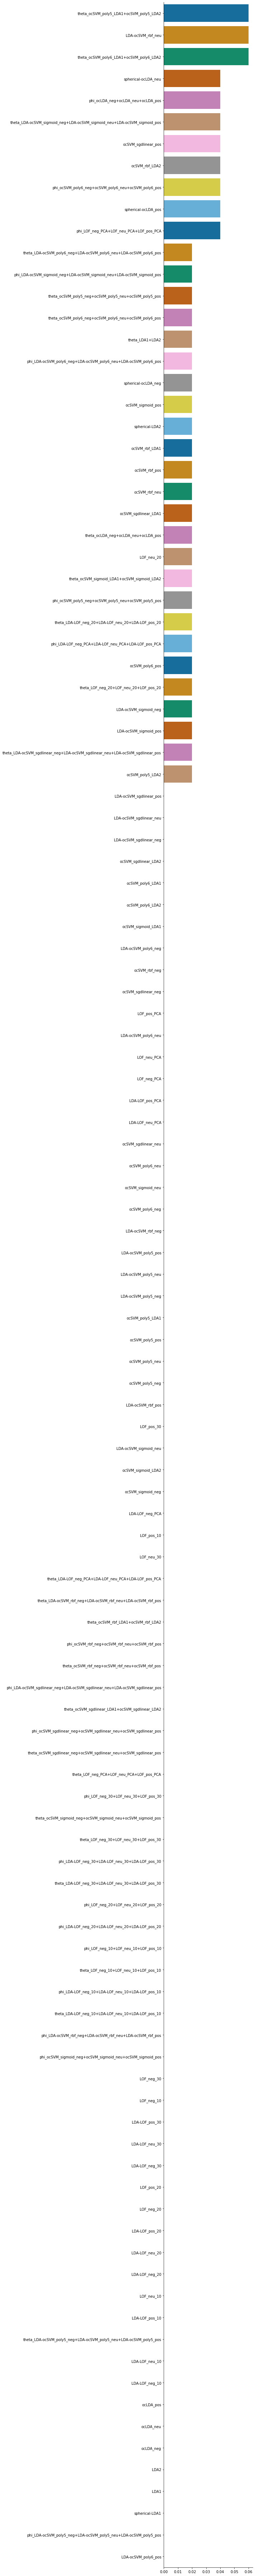

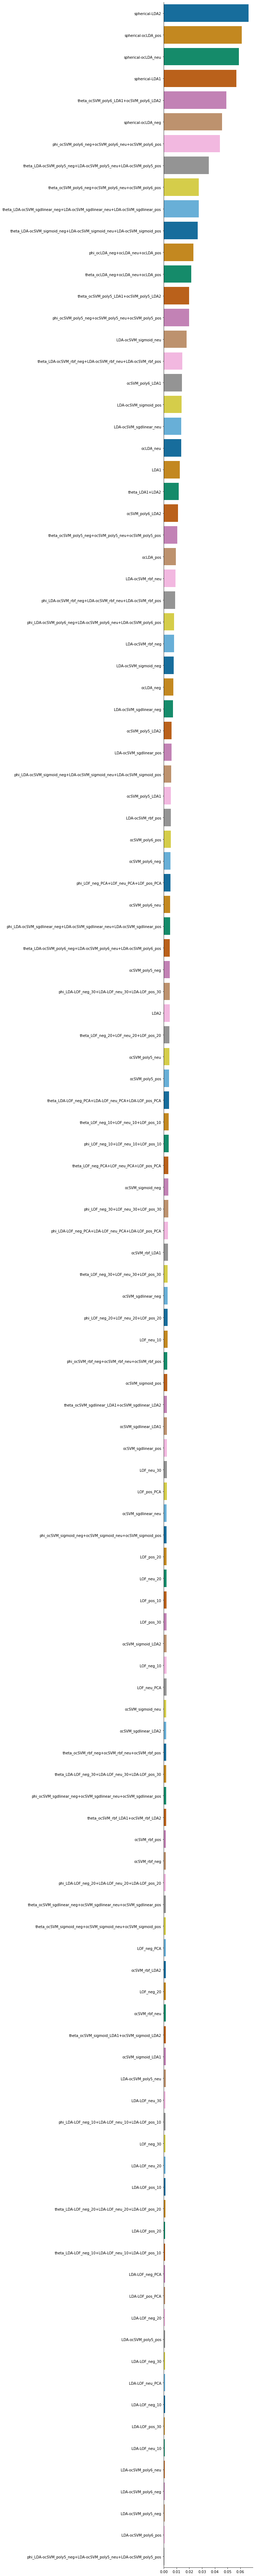

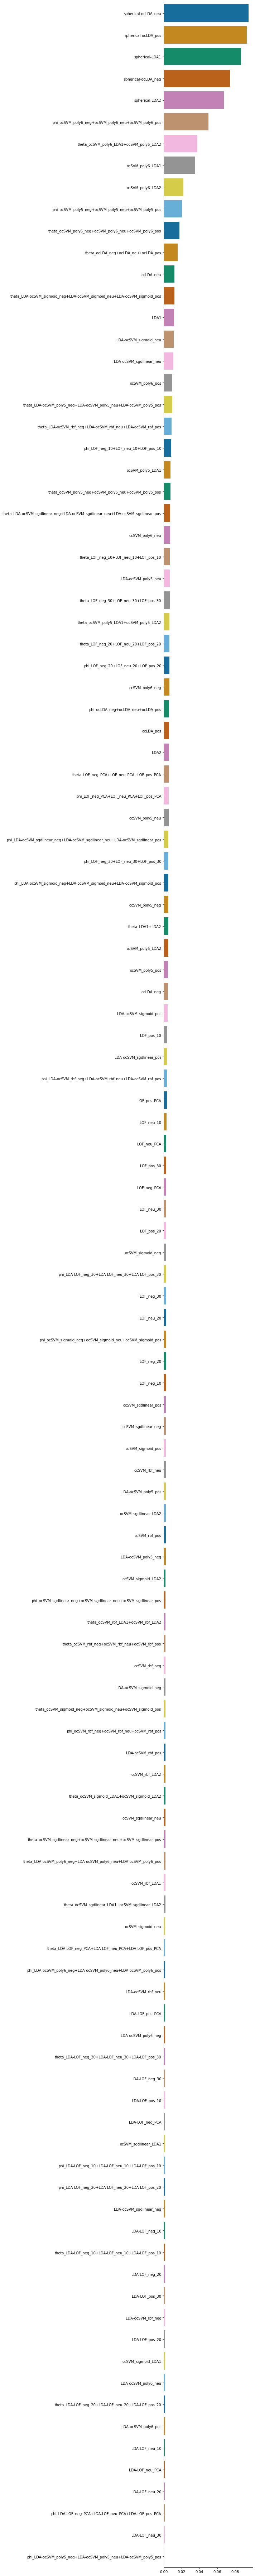

time: 9.39 s


In [11]:
for fitted_tree in fitted_trees:
    plot_importances(fitted_trees[fitted_tree])

Select features

The big spherical LDA components are always in the top. LOF-based features are usually near the bottom. Certain poly6 features are usually the runner up (but not all).

In [12]:
selected_features = {
    "five_sphericals": [
        "spherical-LDA1",
        "spherical-LDA2",
        "spherical-ocLDA_neg",
        "spherical-ocLDA_neu",
        "spherical-ocLDA_pos",
    ],
    "poly6_subset": [
        "ocSVM_poly6_LDA1",
        "ocSVM_poly6_LDA2",
        "phi_ocSVM_poly6_neg+ocSVM_poly6_neu+ocSVM_poly6_pos",
        "theta_ocSVM_poly6_neg+ocSVM_poly6_neu+ocSVM_poly6_pos",
        "theta_ocSVM_poly6_LDA1+ocSVM_poly6_LDA2",
    ],
}
selected_features["five_sphericals+poly6_subset"] = (
    selected_features["five_sphericals"] + selected_features["poly6_subset"]
)
selected_features["three_sphericals"] = [
    "spherical-ocLDA_neg",
    "spherical-ocLDA_neu",
    "spherical-ocLDA_pos",
]
selected_features["two_sphericals"] = ["spherical-LDA1", "spherical-LDA2"]

_ = gc_collect()

time: 146 ms


After

features: five_sphericals


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


AdaBoost
accuracy: 0.8609
roc_auc_ovo: 0.8590
log_loss: 0.9718
ExtraTrees
accuracy: 0.8882
roc_auc_ovo: 0.9819
log_loss: 0.2665


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


RandomForest
accuracy: 0.9291
roc_auc_ovo: 0.9930
log_loss: 0.1819
GaussianNB
accuracy: 0.8845
roc_auc_ovo: 0.9716
log_loss: 0.5781

GaussianNB oob score changed by 0.1877 to 0.8845
extra trees oob score changed by -0.0210 to 0.8754
random forest oob score changed by -0.0509 to 0.8765

AdaBoost
accuracy changed by 0.0537 to 0.8609
roc_auc_ovo changed by -0.0471 to 0.8590
log_loss changed by -0.0384 to 0.9718

ExtraTrees
accuracy changed by -0.0369 to 0.8882
roc_auc_ovo changed by -0.0102 to 0.9819
log_loss changed by 0.0248 to 0.2665

RandomForest
accuracy changed by -0.0583 to 0.9291
roc_auc_ovo changed by -0.0067 to 0.9930
log_loss changed by 0.0964 to 0.1819

GaussianNB
accuracy changed by 0.1874 to 0.8845
roc_auc_ovo changed by 0.0893 to 0.9716
log_loss changed by -1.0711 to 0.5781



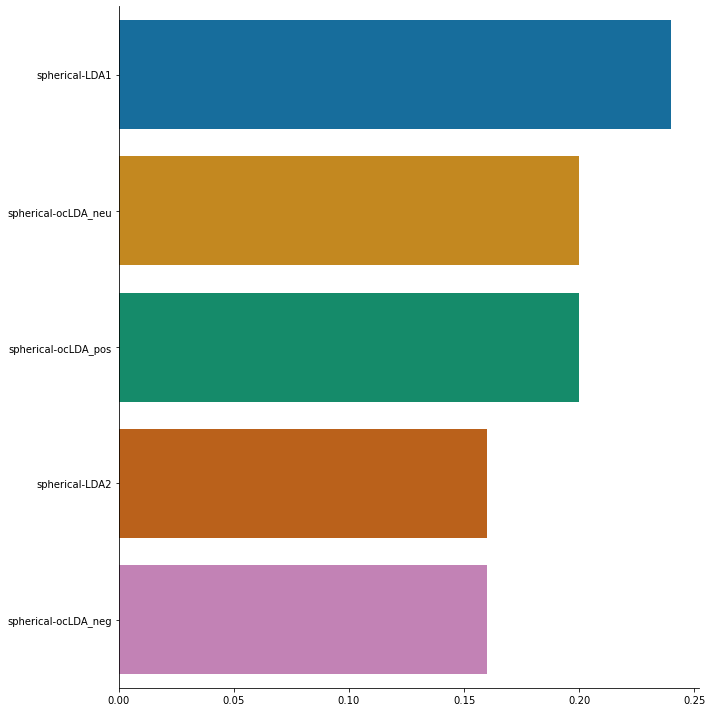

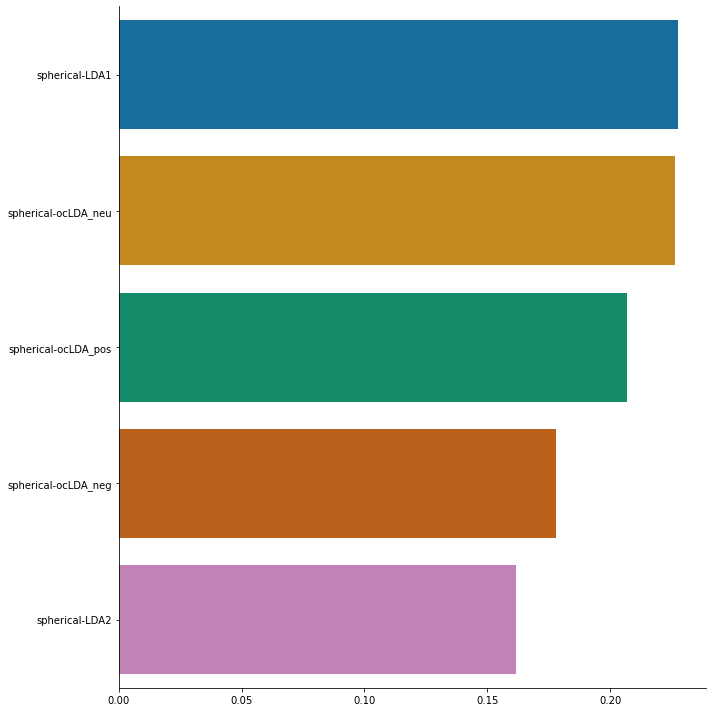

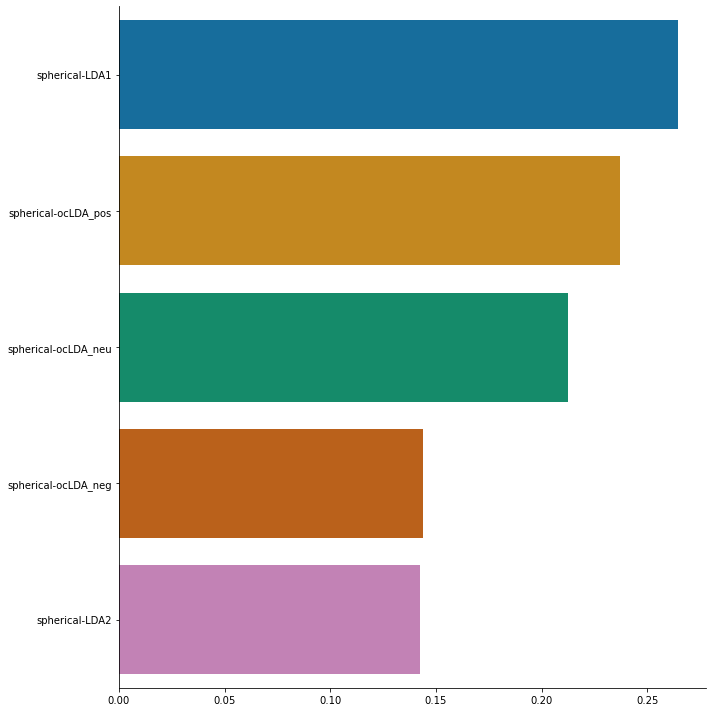

features: poly6_subset


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


AdaBoost
accuracy: 0.8113
roc_auc_ovo: 0.8649
log_loss: 0.9889
ExtraTrees
accuracy: 0.8393
roc_auc_ovo: 0.9712
log_loss: 0.3561


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


RandomForest
accuracy: 0.9199
roc_auc_ovo: 0.9922
log_loss: 0.2122
GaussianNB
accuracy: 0.8170
roc_auc_ovo: 0.9381
log_loss: 0.6281

GaussianNB oob score changed by 0.1201 to 0.8170
extra trees oob score changed by -0.0735 to 0.8229
random forest oob score changed by -0.0910 to 0.8364

AdaBoost
accuracy changed by 0.0041 to 0.8113
roc_auc_ovo changed by -0.0413 to 0.8649
log_loss changed by -0.0213 to 0.9889

ExtraTrees
accuracy changed by -0.0858 to 0.8393
roc_auc_ovo changed by -0.0209 to 0.9712
log_loss changed by 0.1144 to 0.3561

RandomForest
accuracy changed by -0.0675 to 0.9199
roc_auc_ovo changed by -0.0075 to 0.9922
log_loss changed by 0.1267 to 0.2122

GaussianNB
accuracy changed by 0.1199 to 0.8170
roc_auc_ovo changed by 0.0558 to 0.9381
log_loss changed by -1.0211 to 0.6281



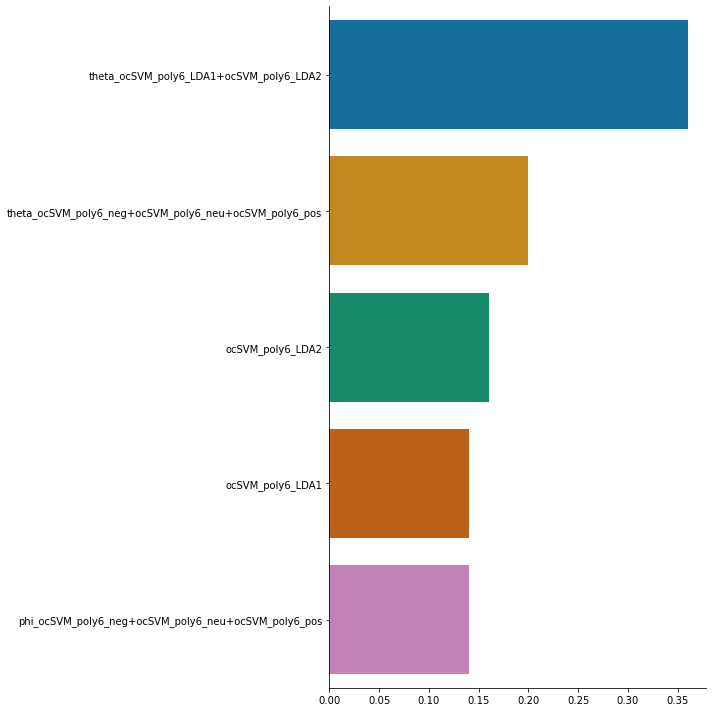

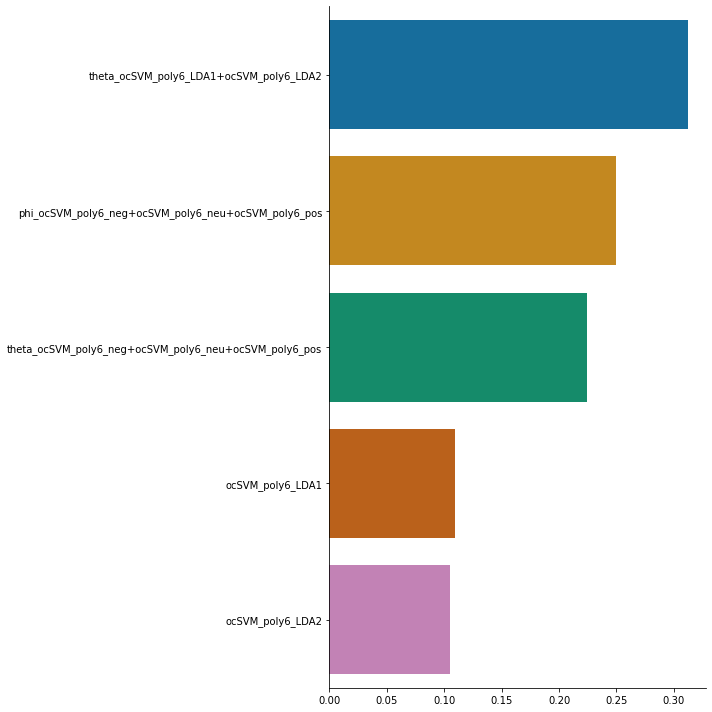

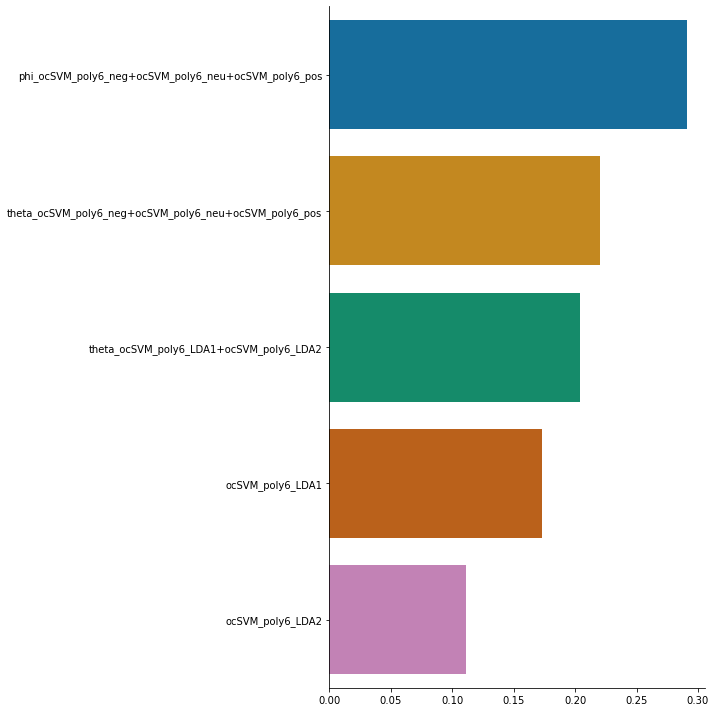

features: five_sphericals+poly6_subset


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


AdaBoost
accuracy: 0.8669
roc_auc_ovo: 0.8713
log_loss: 0.9643
ExtraTrees
accuracy: 0.9005
roc_auc_ovo: 0.9864
log_loss: 0.2407


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


RandomForest
accuracy: 0.9576
roc_auc_ovo: 0.9973
log_loss: 0.1348
GaussianNB
accuracy: 0.8822
roc_auc_ovo: 0.9704
log_loss: 0.7980

GaussianNB oob score changed by 0.1853 to 0.8822
extra trees oob score changed by -0.0104 to 0.8861
random forest oob score changed by -0.0326 to 0.8949

AdaBoost
accuracy changed by 0.0597 to 0.8669
roc_auc_ovo changed by -0.0349 to 0.8713
log_loss changed by -0.0459 to 0.9643

ExtraTrees
accuracy changed by -0.0245 to 0.9005
roc_auc_ovo changed by -0.0057 to 0.9864
log_loss changed by -0.0010 to 0.2407

RandomForest
accuracy changed by -0.0298 to 0.9576
roc_auc_ovo changed by -0.0024 to 0.9973
log_loss changed by 0.0493 to 0.1348

GaussianNB
accuracy changed by 0.1850 to 0.8822
roc_auc_ovo changed by 0.0881 to 0.9704
log_loss changed by -0.8513 to 0.7980



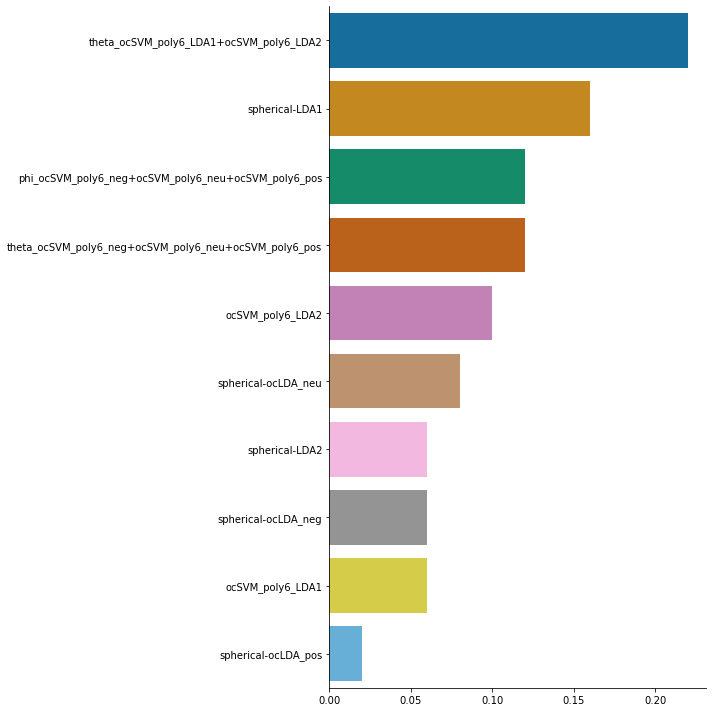

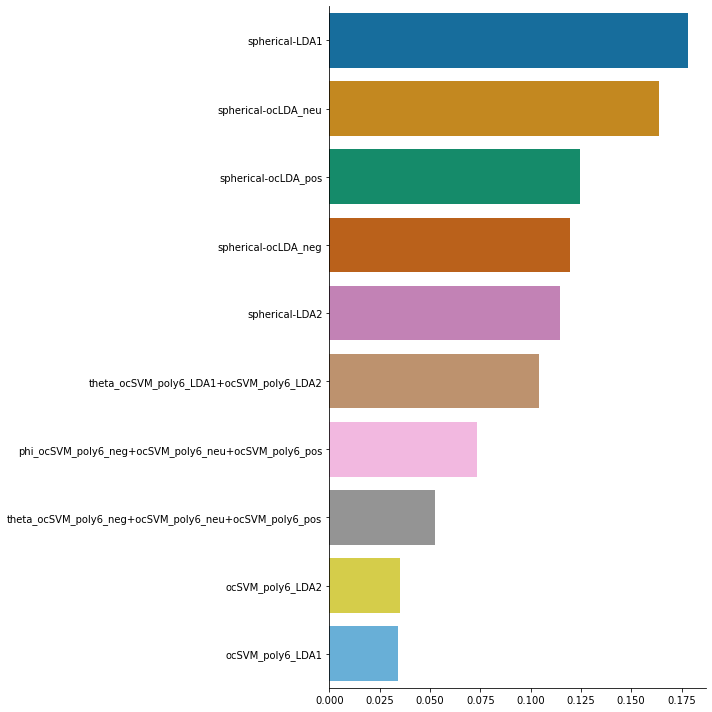

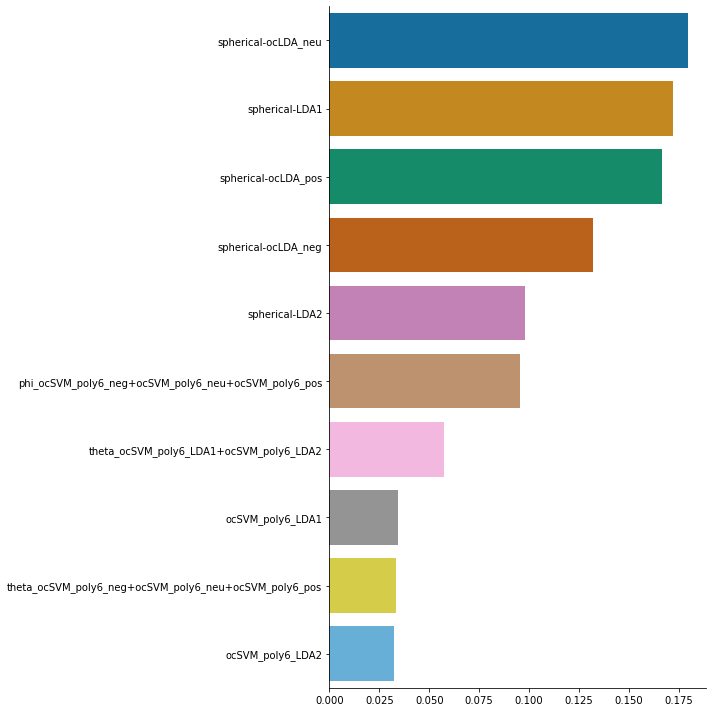

features: three_sphericals


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


AdaBoost
accuracy: 0.8688
roc_auc_ovo: 0.9320
log_loss: 0.9777
ExtraTrees
accuracy: 0.8763
roc_auc_ovo: 0.9772
log_loss: 0.3070


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


RandomForest
accuracy: 0.9287
roc_auc_ovo: 0.9927
log_loss: 0.1843
GaussianNB
accuracy: 0.8844
roc_auc_ovo: 0.9719
log_loss: 0.3862

GaussianNB oob score changed by 0.1876 to 0.8844
extra trees oob score changed by -0.0256 to 0.8709
random forest oob score changed by -0.0504 to 0.8770

AdaBoost
accuracy changed by 0.0617 to 0.8688
roc_auc_ovo changed by 0.0259 to 0.9320
log_loss changed by -0.0325 to 0.9777

ExtraTrees
accuracy changed by -0.0488 to 0.8763
roc_auc_ovo changed by -0.0149 to 0.9772
log_loss changed by 0.0654 to 0.3070

RandomForest
accuracy changed by -0.0587 to 0.9287
roc_auc_ovo changed by -0.0070 to 0.9927
log_loss changed by 0.0988 to 0.1843

GaussianNB
accuracy changed by 0.1872 to 0.8844
roc_auc_ovo changed by 0.0896 to 0.9719
log_loss changed by -1.2631 to 0.3862



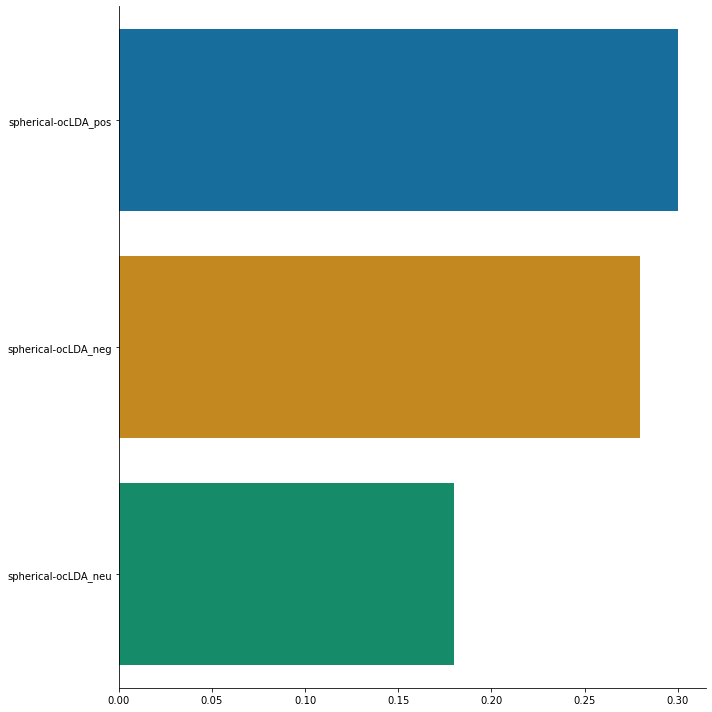

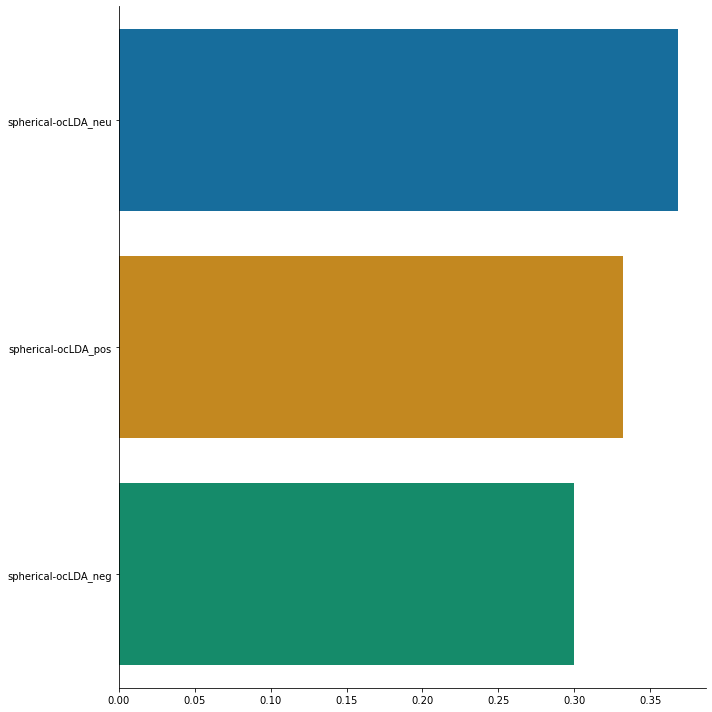

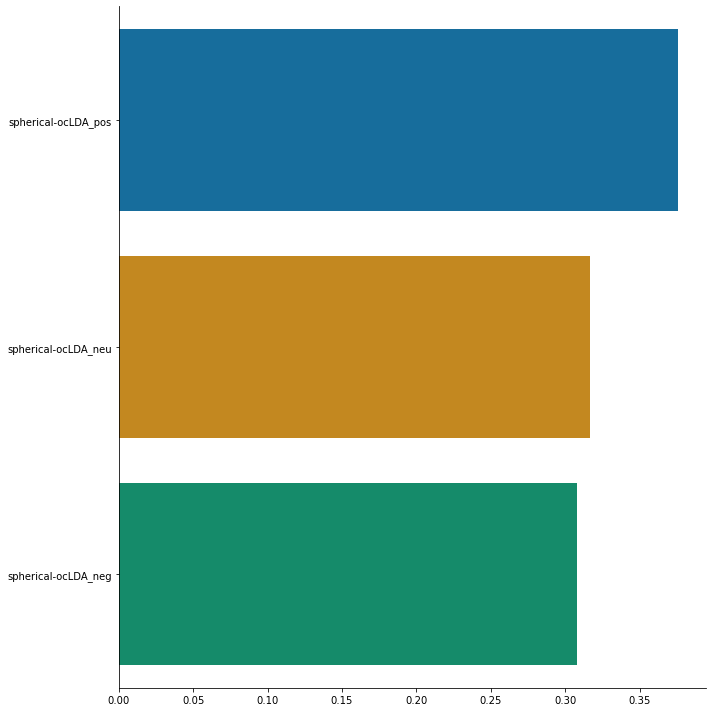

features: two_sphericals


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


AdaBoost
accuracy: 0.8641
roc_auc_ovo: 0.8947
log_loss: 0.9668
ExtraTrees
accuracy: 0.8785
roc_auc_ovo: 0.9779
log_loss: 0.3045


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


RandomForest
accuracy: 0.9207
roc_auc_ovo: 0.9916
log_loss: 0.1932
GaussianNB
accuracy: 0.8804
roc_auc_ovo: 0.9695
log_loss: 0.3560

GaussianNB oob score changed by 0.1835 to 0.8804
extra trees oob score changed by -0.0236 to 0.8729
random forest oob score changed by -0.0513 to 0.8761

AdaBoost
accuracy changed by 0.0570 to 0.8641
roc_auc_ovo changed by -0.0114 to 0.8947
log_loss changed by -0.0435 to 0.9668

ExtraTrees
accuracy changed by -0.0465 to 0.8785
roc_auc_ovo changed by -0.0142 to 0.9779
log_loss changed by 0.0628 to 0.3045

RandomForest
accuracy changed by -0.0667 to 0.9207
roc_auc_ovo changed by -0.0081 to 0.9916
log_loss changed by 0.1076 to 0.1932

GaussianNB
accuracy changed by 0.1832 to 0.8804
roc_auc_ovo changed by 0.0872 to 0.9695
log_loss changed by -1.2932 to 0.3560



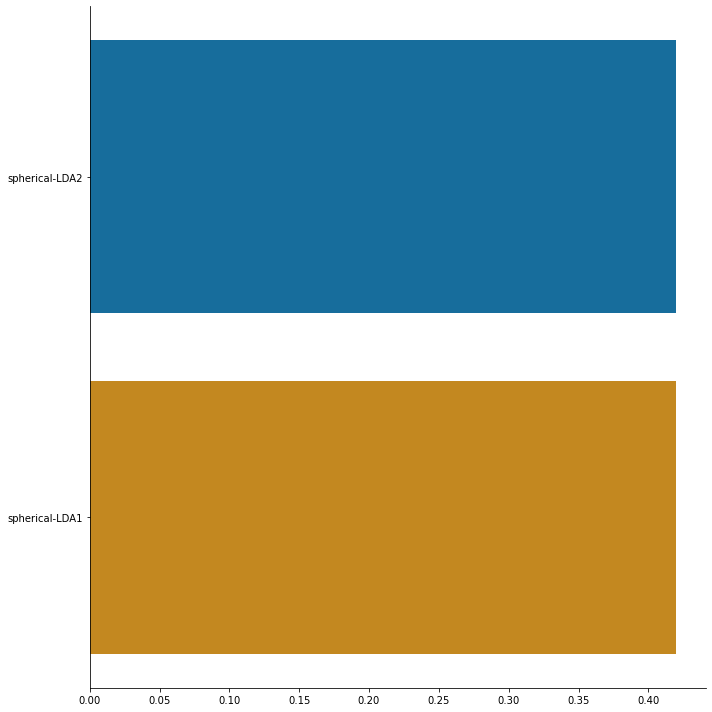

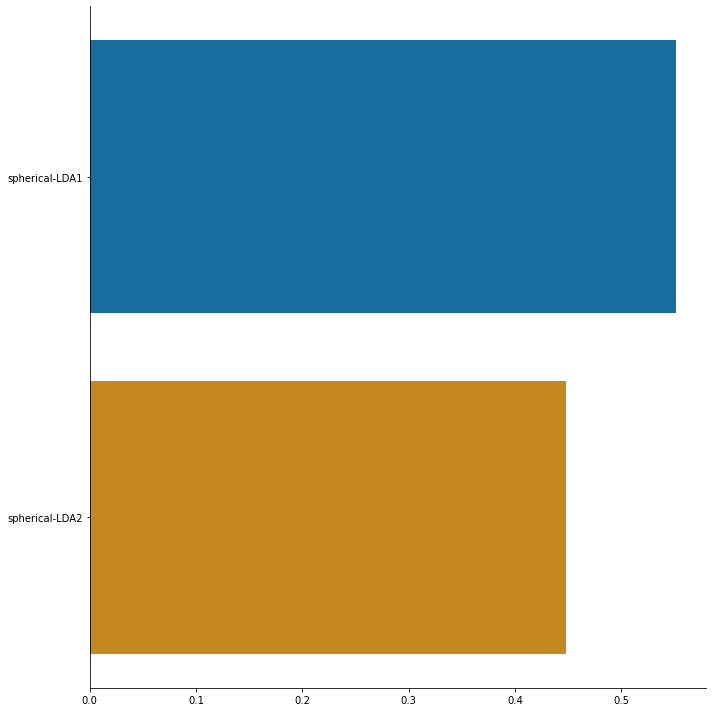

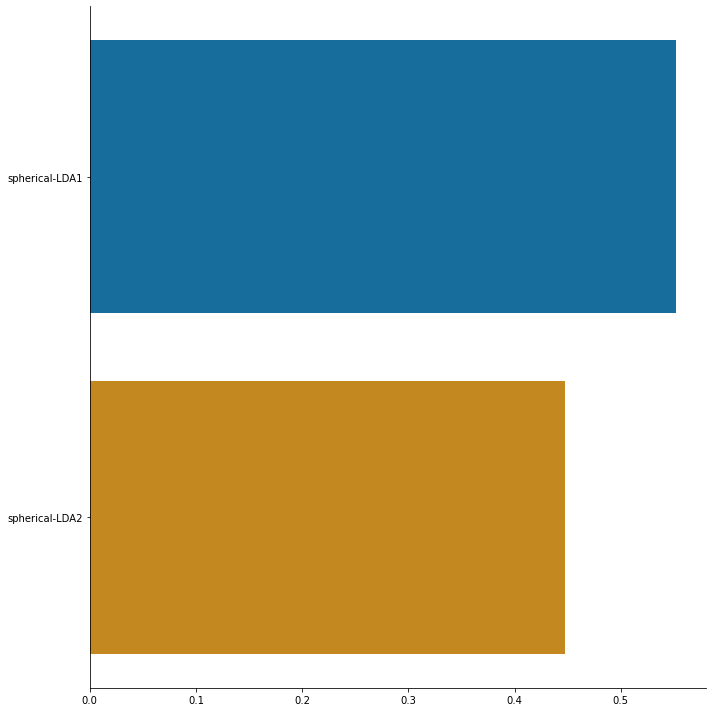

time: 1min 28s


In [13]:
for selected in selected_features.keys():
    print("features:", selected)
    data = load_data(unscaled=True).loc[:, selected_features[selected]]
    fitted_models = {
        **(fitted_trees := fit_trees(data, y_true)),
        "GaussianNB": make_gnb().fit(data, y_true),
    }
    scores_after = {k: score_model(v, k, data) for k, v in fitted_models.items()}
    print()
    print(
        f"GaussianNB oob score changed by {(_ := fitted_models['GaussianNB'].oob_score_) - oob_gnb:.4f} to {_:.4f}"
    )
    print(
        f"extra trees oob score changed by {(_ := fitted_trees['ExtraTrees'].oob_score_) - oob_extra:.4f} to {_:.4f}"
    )
    print(
        f"random forest oob score changed by {(_ := fitted_trees['RandomForest'].oob_score_) - oob_rf:.4f} to {_:.4f}"
    )
    print()
    for model in fitted_models.keys():
        before = scores_before[model]
        after = scores_after[model]
        print(model)
        for score in ("accuracy", "roc_auc_ovo", "log_loss"):
            print(
                f"{score} changed by {after[score] - before[score]:.4f} to {after[score]:.4f}"
            )
        print()
    for fitted_tree in fitted_trees:
        plot_importances(fitted_trees[fitted_tree], fig_height=10)

SelectFromModel

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


selecting with AdaBoost


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


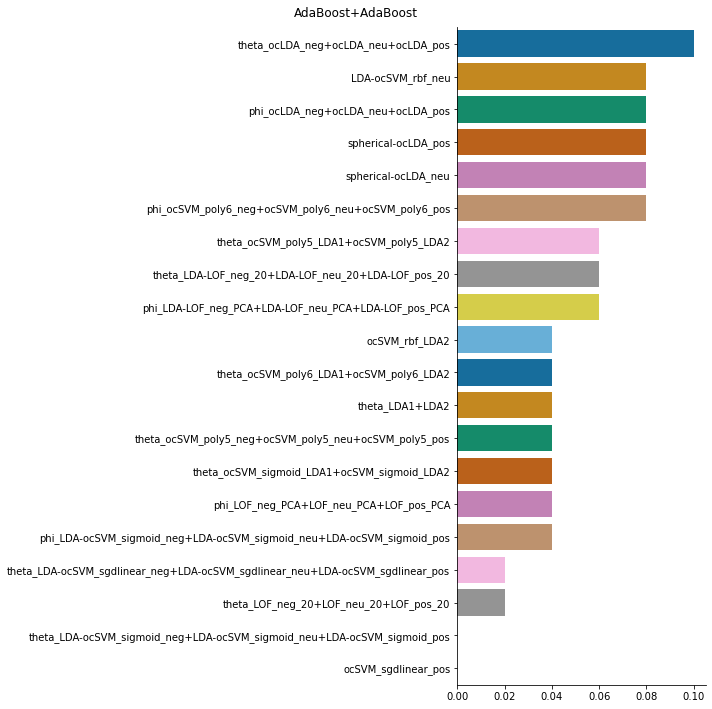

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(


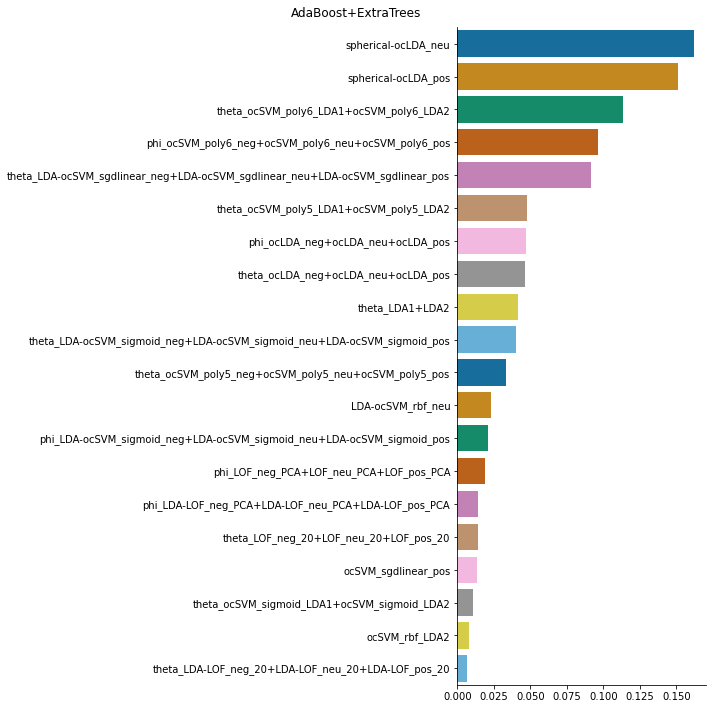

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


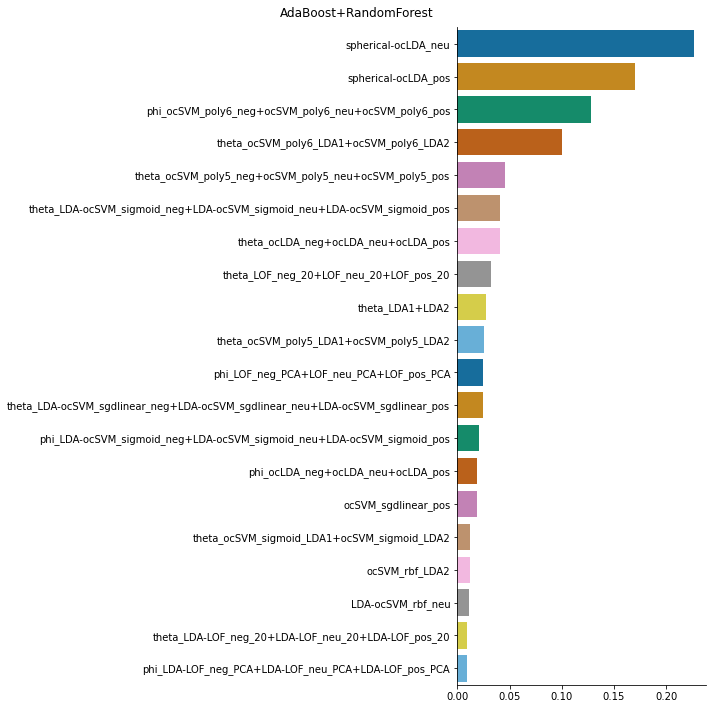

GaussianNB oob score changed by 0.0818 to 0.7786
extra trees oob score changed by -0.0132 to 0.8832
random forest oob score changed by -0.0090 to 0.9184

AdaBoost+AdaBoost
accuracy: 0.8673
roc_auc_ovo: 0.9356
log_loss: 1.0289
AdaBoost+ExtraTrees
accuracy: 0.9040
roc_auc_ovo: 0.9878
log_loss: 0.2704


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


AdaBoost+RandomForest
accuracy: 0.9754
roc_auc_ovo: 0.9990
log_loss: 0.1080
AdaBoost+GaussianNB
accuracy: 0.7787
roc_auc_ovo: 0.9464
log_loss: 1.5822

with feature selection by AdaBoost...
AdaBoost's accuracy changed by 0.0601 from 0.8072 to 0.8673
AdaBoost's roc_auc_ovo changed by 0.0295 from 0.9061 to 0.9356
AdaBoost's log_loss changed by 0.0187 from 1.0102 to 1.0289
ExtraTrees's accuracy changed by -0.0210 from 0.9250 to 0.9040
ExtraTrees's roc_auc_ovo changed by -0.0043 from 0.9921 to 0.9878
ExtraTrees's log_loss changed by 0.0287 from 0.2417 to 0.2704
RandomForest's accuracy changed by -0.0120 from 0.9874 to 0.9754
RandomForest's roc_auc_ovo changed by -0.0007 from 0.9997 to 0.9990
RandomForest's log_loss changed by 0.0225 from 0.0855 to 0.1080
GaussianNB's accuracy changed by 0.0816 from 0.6972 to 0.7787
GaussianNB's roc_auc_ovo changed by 0.0641 from 0.8823 to 0.9464
GaussianNB's log_loss changed by -0.0671 from 1.6493 to 1.5822

selecting with ExtraTrees


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


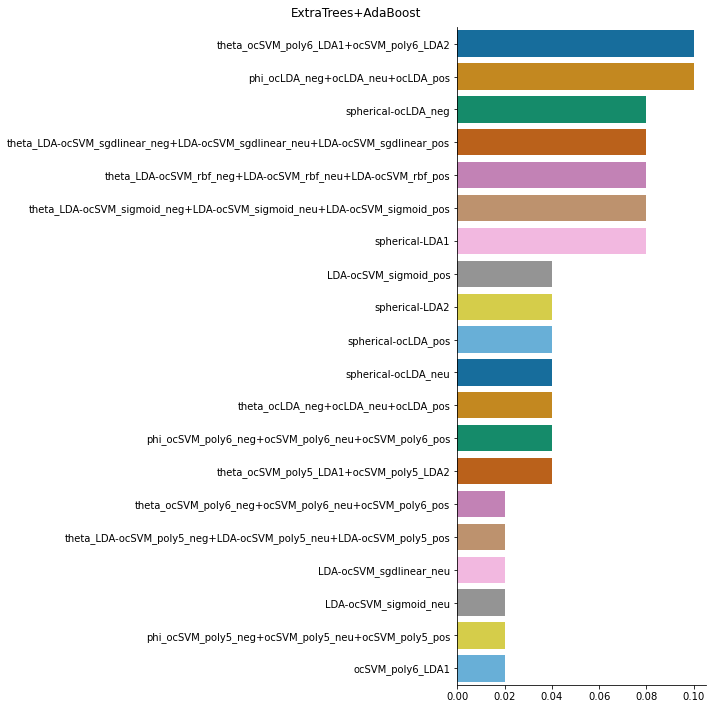

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(


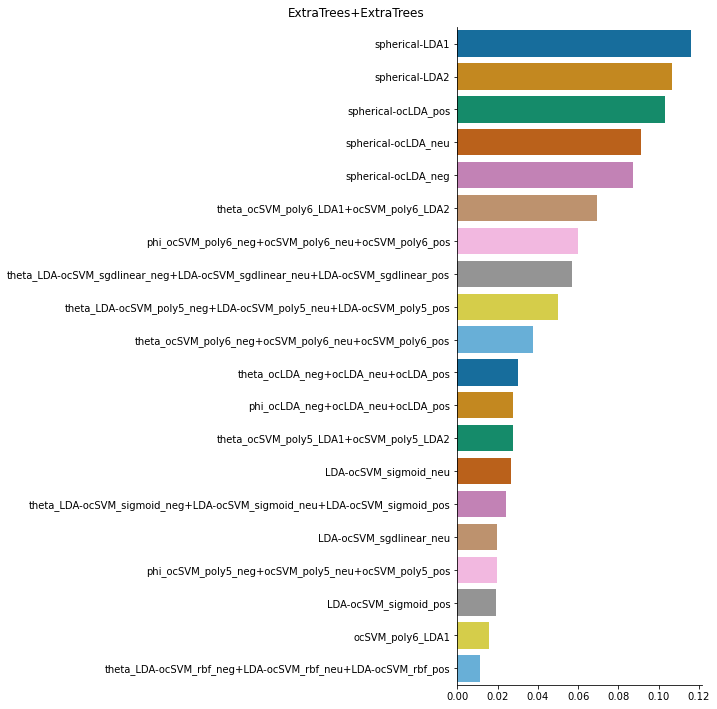

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


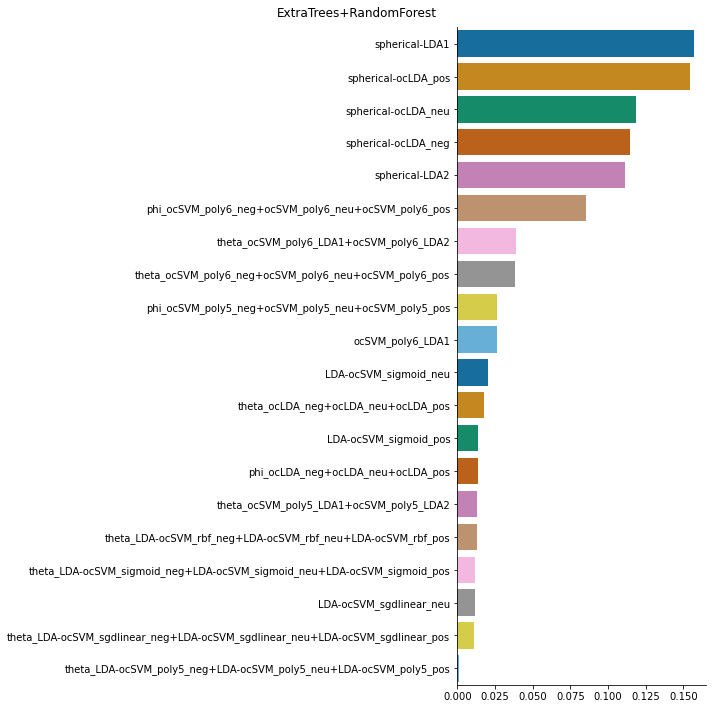

GaussianNB oob score changed by 0.1429 to 0.8398
extra trees oob score changed by -0.0007 to 0.8958
random forest oob score changed by -0.0172 to 0.9102

ExtraTrees+AdaBoost
accuracy: 0.8600
roc_auc_ovo: 0.8633
log_loss: 0.9824
ExtraTrees+ExtraTrees
accuracy: 0.9120
roc_auc_ovo: 0.9888
log_loss: 0.2305


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


ExtraTrees+RandomForest
accuracy: 0.9675
roc_auc_ovo: 0.9983
log_loss: 0.1164
ExtraTrees+GaussianNB
accuracy: 0.8398
roc_auc_ovo: 0.9589
log_loss: 1.6404

with feature selection by ExtraTrees...
AdaBoost's accuracy changed by 0.0528 from 0.8072 to 0.8600
AdaBoost's roc_auc_ovo changed by -0.0429 from 0.9061 to 0.8633
AdaBoost's log_loss changed by -0.0278 from 1.0102 to 0.9824
ExtraTrees's accuracy changed by -0.0130 from 0.9250 to 0.9120
ExtraTrees's roc_auc_ovo changed by -0.0033 from 0.9921 to 0.9888
ExtraTrees's log_loss changed by -0.0112 from 0.2417 to 0.2305
RandomForest's accuracy changed by -0.0199 from 0.9874 to 0.9675
RandomForest's roc_auc_ovo changed by -0.0014 from 0.9997 to 0.9983
RandomForest's log_loss changed by 0.0309 from 0.0855 to 0.1164
GaussianNB's accuracy changed by 0.1426 from 0.6972 to 0.8398
GaussianNB's roc_auc_ovo changed by 0.0765 from 0.8823 to 0.9589
GaussianNB's log_loss changed by -0.0089 from 1.6493 to 1.6404

selecting with RandomForest


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


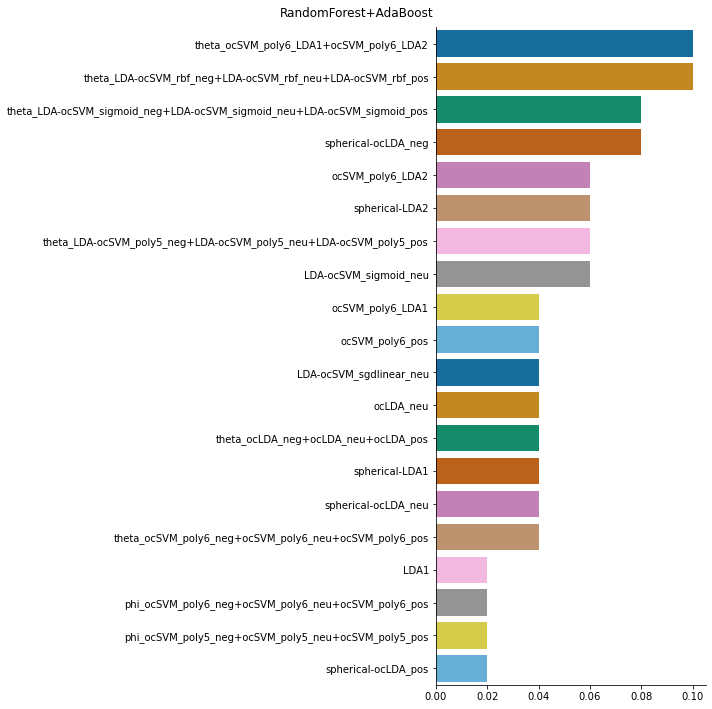

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(


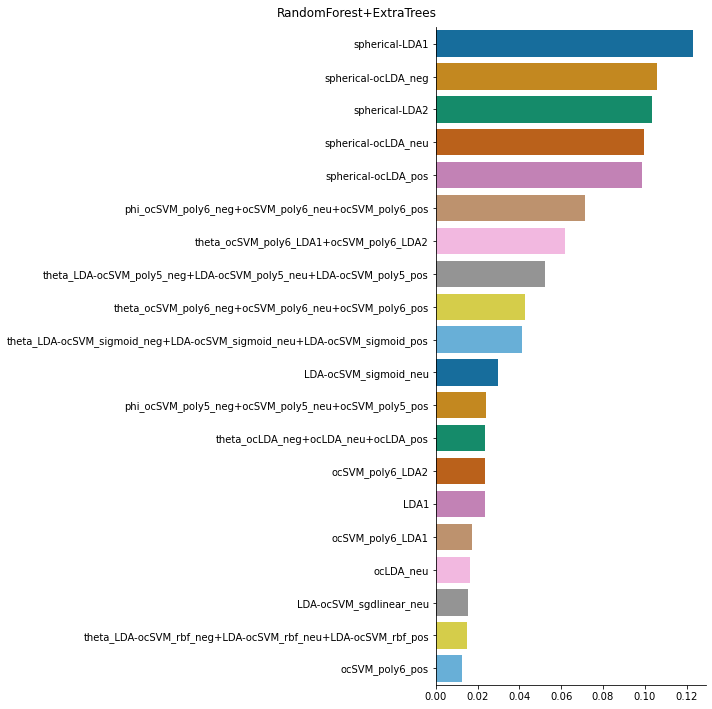

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


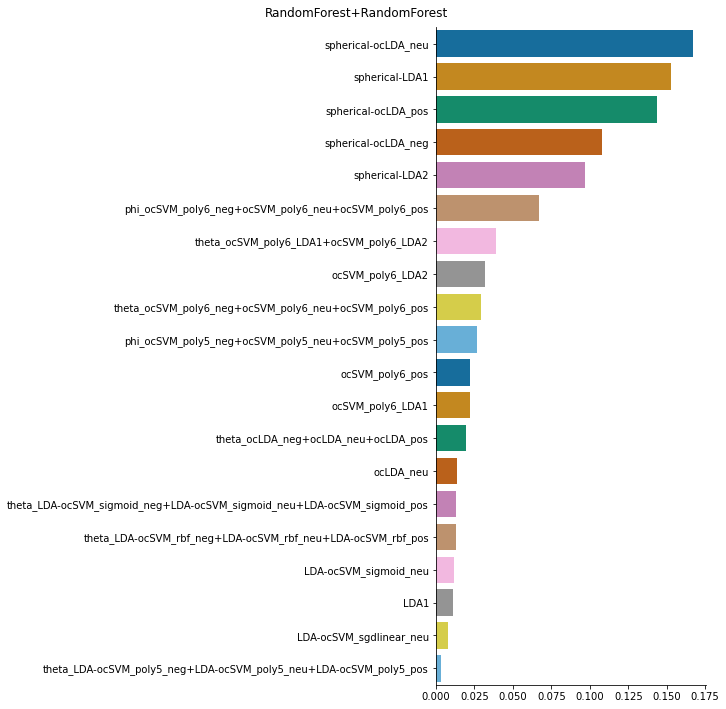

GaussianNB oob score changed by 0.1541 to 0.8509
extra trees oob score changed by -0.0008 to 0.8956
random forest oob score changed by -0.0153 to 0.9121

RandomForest+AdaBoost
accuracy: 0.8783
roc_auc_ovo: 0.9121
log_loss: 0.9962
RandomForest+ExtraTrees
accuracy: 0.9121
roc_auc_ovo: 0.9888
log_loss: 0.2304


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


RandomForest+RandomForest
accuracy: 0.9681
roc_auc_ovo: 0.9984
log_loss: 0.1137
RandomForest+GaussianNB
accuracy: 0.8509
roc_auc_ovo: 0.9600
log_loss: 1.5185

with feature selection by RandomForest...
AdaBoost's accuracy changed by 0.0711 from 0.8072 to 0.8783
AdaBoost's roc_auc_ovo changed by 0.0060 from 0.9061 to 0.9121
AdaBoost's log_loss changed by -0.0141 from 1.0102 to 0.9962
ExtraTrees's accuracy changed by -0.0129 from 0.9250 to 0.9121
ExtraTrees's roc_auc_ovo changed by -0.0033 from 0.9921 to 0.9888
ExtraTrees's log_loss changed by -0.0113 from 0.2417 to 0.2304
RandomForest's accuracy changed by -0.0193 from 0.9874 to 0.9681
RandomForest's roc_auc_ovo changed by -0.0013 from 0.9997 to 0.9984
RandomForest's log_loss changed by 0.0282 from 0.0855 to 0.1137
GaussianNB's accuracy changed by 0.1538 from 0.6972 to 0.8509
GaussianNB's roc_auc_ovo changed by 0.0776 from 0.8823 to 0.9600
GaussianNB's log_loss changed by -0.1308 from 1.6493 to 1.5185

time: 2min 8s


In [14]:
data = load_data(unscaled=True)
fitted_trees = fit_trees(data, y_true)
selectors = {
    model_name: SelectFromModel(estimator=fitted_model, prefit=True, max_features=20)
    for model_name, fitted_model in fitted_trees.items()
}
for selector_estimator, selector in selectors.items():
    print(f"selecting with {selector_estimator}")

    data_ = pd.DataFrame(
        selector.transform(data), columns=selector.get_feature_names_out(data.columns)
    )
    fitted_models: Dict[str, BaseEstimator] = {}

    for ensemble_name, fitted_tree in deepcopy(fitted_trees).items():
        fitted_models[
            f"{selector_estimator}+{ensemble_name}"
        ] = fitted_tree.fit(  # re-fit
            data_, y_true
        )
        plot_importances(
            fitted_tree, fig_height=10, title=f"{selector_estimator}+{ensemble_name}"
        )
    fitted_models[f"{selector_estimator}+GaussianNB"] = make_gnb().fit(data_, y_true)
    print(
        f"GaussianNB oob score changed by {(_ := fitted_models[f'{selector_estimator}+GaussianNB'].oob_score_) - oob_gnb:.4f} to {_:.4f}"
    )
    print(
        f"extra trees oob score changed by {(_ := fitted_models[f'{selector_estimator}+ExtraTrees'].oob_score_) - oob_extra:.4f} to {_:.4f}"
    )
    print(
        f"random forest oob score changed by {(_ := fitted_models[f'{selector_estimator}+RandomForest'].oob_score_) - oob_rf:.4f} to {_:.4f}"
    )
    print()

    scores_after: Dict[str, Dict[str, float]] = {
        k: score_model(v, k, data=data_) for k, v in fitted_models.items()
    }

    print(f"\nwith feature selection by {selector_estimator}...")
    for after_model, after_score_dict in scores_before.items():
        after_scores: Dict[str, float] = scores_after[
            f"{selector_estimator}+{after_model}"
        ]
        before_scores: Dict[str, float] = scores_before[after_model]
        base_model = after_model.split("+")[-1]
        for scorer, score in after_scores.items():
            print(
                f"{base_model}'s {scorer} changed by {(after := after_scores[scorer]) - (before := before_scores[scorer]):.4f} from {before:.4f} to {after:.4f}"
            )
    print()

Once more with max_features=18

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


selecting with AdaBoost


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


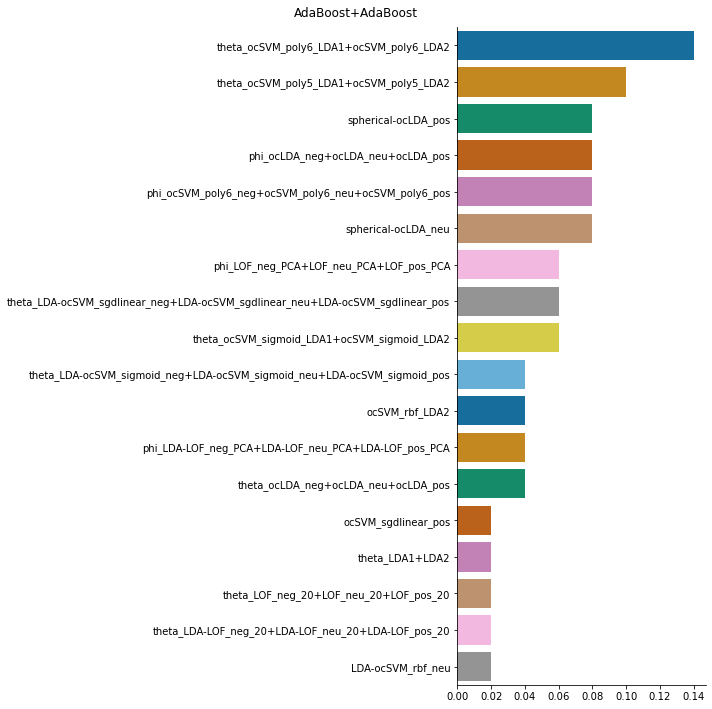

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(


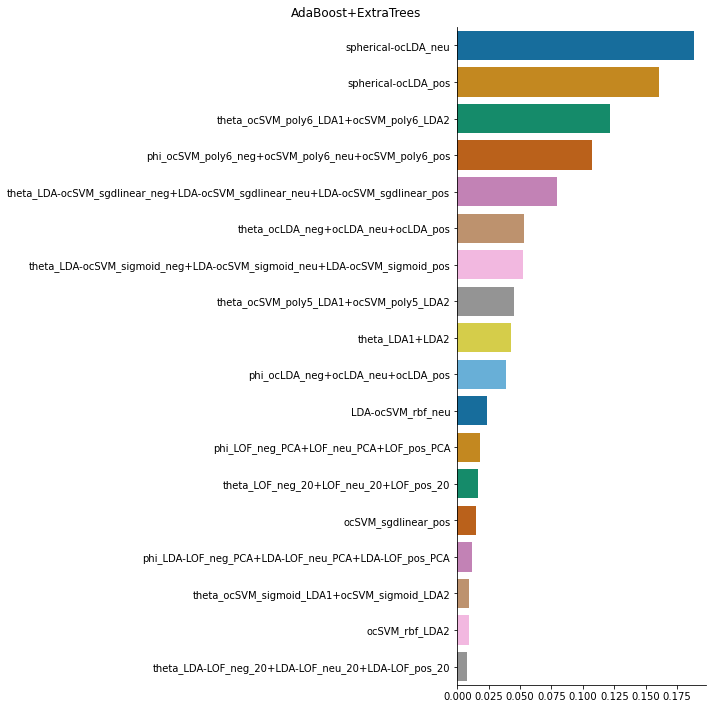

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


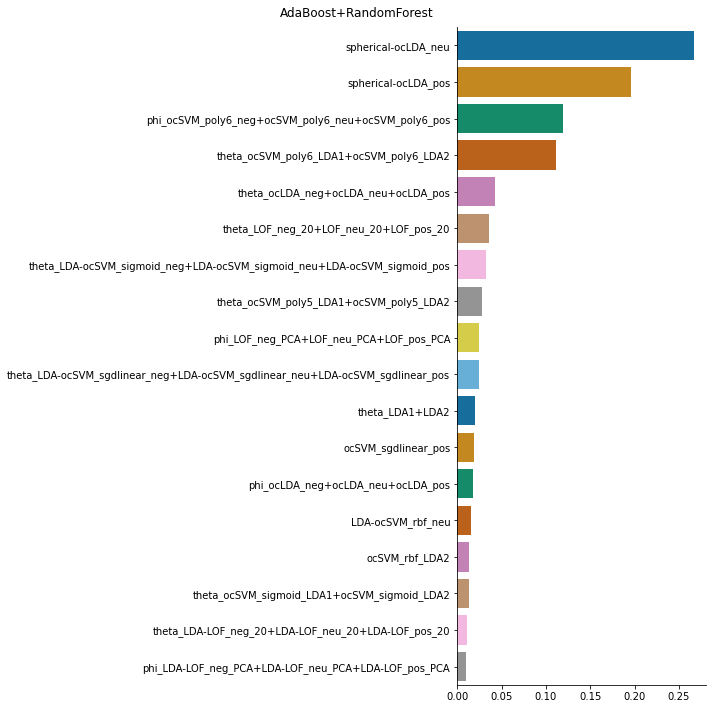

GaussianNB oob score changed by 0.0772 to 0.7740
extra trees oob score changed by -0.0101 to 0.8864
random forest oob score changed by -0.0080 to 0.9194

AdaBoost+AdaBoost
accuracy: 0.8774
roc_auc_ovo: 0.9305
log_loss: 1.0233
AdaBoost+ExtraTrees
accuracy: 0.9082
roc_auc_ovo: 0.9888
log_loss: 0.2606


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


AdaBoost+RandomForest
accuracy: 0.9764
roc_auc_ovo: 0.9991
log_loss: 0.1047
AdaBoost+GaussianNB
accuracy: 0.7741
roc_auc_ovo: 0.9493
log_loss: 1.4276

with feature selection by AdaBoost...
AdaBoost's accuracy changed by 0.0702 from 0.8072 to 0.8774
AdaBoost's roc_auc_ovo changed by 0.0244 from 0.9061 to 0.9305
AdaBoost's log_loss changed by 0.0131 from 1.0102 to 1.0233
ExtraTrees's accuracy changed by -0.0169 from 0.9250 to 0.9082
ExtraTrees's roc_auc_ovo changed by -0.0033 from 0.9921 to 0.9888
ExtraTrees's log_loss changed by 0.0189 from 0.2417 to 0.2606
RandomForest's accuracy changed by -0.0110 from 0.9874 to 0.9764
RandomForest's roc_auc_ovo changed by -0.0006 from 0.9997 to 0.9991
RandomForest's log_loss changed by 0.0192 from 0.0855 to 0.1047
GaussianNB's accuracy changed by 0.0769 from 0.6972 to 0.7741
GaussianNB's roc_auc_ovo changed by 0.0670 from 0.8823 to 0.9493
GaussianNB's log_loss changed by -0.2217 from 1.6493 to 1.4276

selecting with ExtraTrees


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


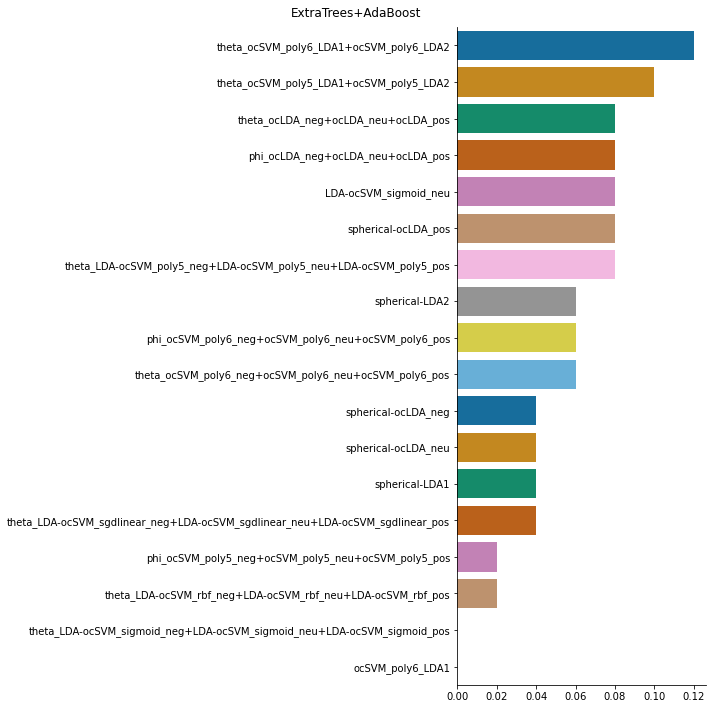

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(


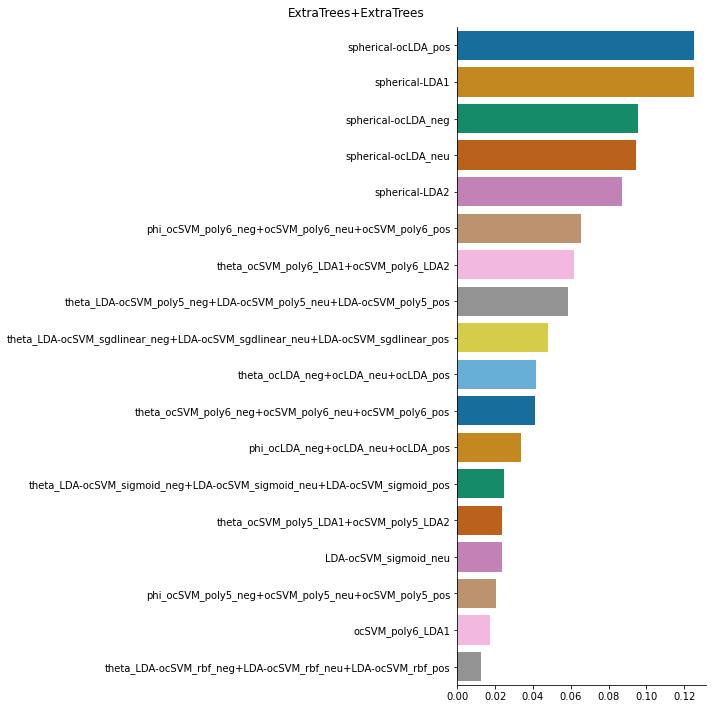

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


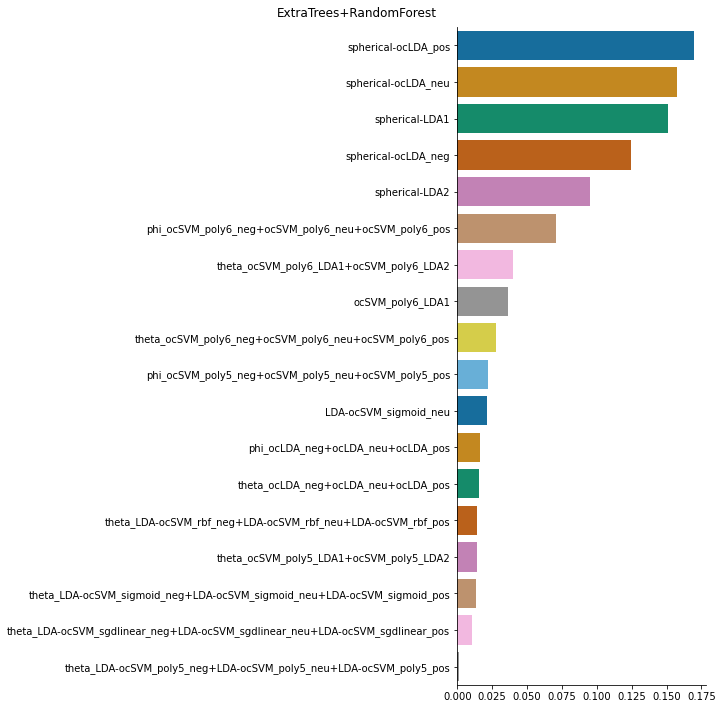

GaussianNB oob score changed by 0.1474 to 0.8442
extra trees oob score changed by -0.0002 to 0.8963
random forest oob score changed by -0.0185 to 0.9089

ExtraTrees+AdaBoost
accuracy: 0.8728
roc_auc_ovo: 0.9599
log_loss: 1.0171
ExtraTrees+ExtraTrees
accuracy: 0.9126
roc_auc_ovo: 0.9890
log_loss: 0.2266


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


ExtraTrees+RandomForest
accuracy: 0.9669
roc_auc_ovo: 0.9983
log_loss: 0.1165
ExtraTrees+GaussianNB
accuracy: 0.8442
roc_auc_ovo: 0.9606
log_loss: 1.4791

with feature selection by ExtraTrees...
AdaBoost's accuracy changed by 0.0657 from 0.8072 to 0.8728
AdaBoost's roc_auc_ovo changed by 0.0538 from 0.9061 to 0.9599
AdaBoost's log_loss changed by 0.0069 from 1.0102 to 1.0171
ExtraTrees's accuracy changed by -0.0124 from 0.9250 to 0.9126
ExtraTrees's roc_auc_ovo changed by -0.0030 from 0.9921 to 0.9890
ExtraTrees's log_loss changed by -0.0150 from 0.2417 to 0.2266
RandomForest's accuracy changed by -0.0205 from 0.9874 to 0.9669
RandomForest's roc_auc_ovo changed by -0.0014 from 0.9997 to 0.9983
RandomForest's log_loss changed by 0.0310 from 0.0855 to 0.1165
GaussianNB's accuracy changed by 0.1470 from 0.6972 to 0.8442
GaussianNB's roc_auc_ovo changed by 0.0783 from 0.8823 to 0.9606
GaussianNB's log_loss changed by -0.1701 from 1.6493 to 1.4791

selecting with RandomForest


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


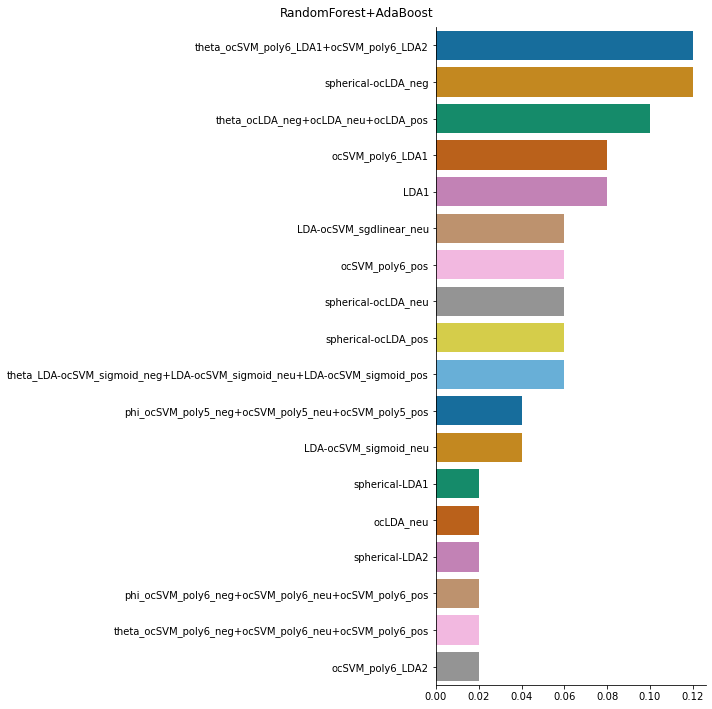

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(


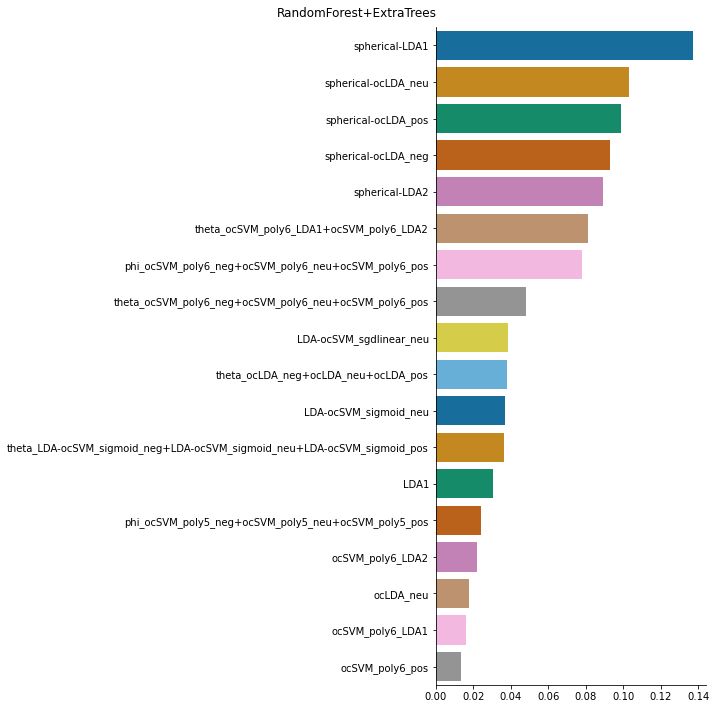

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


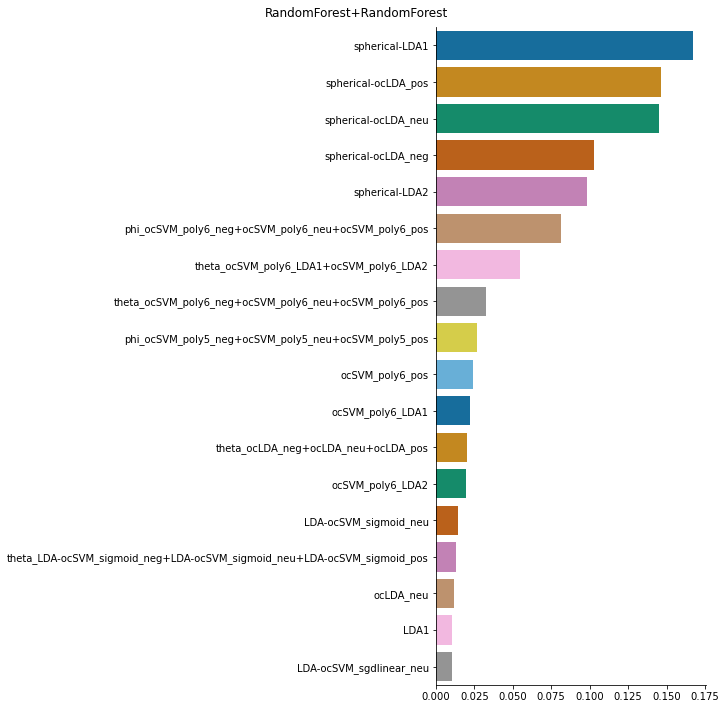

GaussianNB oob score changed by 0.1611 to 0.8580
extra trees oob score changed by -0.0006 to 0.8959
random forest oob score changed by -0.0151 to 0.9123

RandomForest+AdaBoost
accuracy: 0.8584
roc_auc_ovo: 0.9461
log_loss: 1.0115
RandomForest+ExtraTrees
accuracy: 0.9120
roc_auc_ovo: 0.9889
log_loss: 0.2286


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


RandomForest+RandomForest
accuracy: 0.9695
roc_auc_ovo: 0.9985
log_loss: 0.1112
RandomForest+GaussianNB
accuracy: 0.8580
roc_auc_ovo: 0.9627
log_loss: 1.3198

with feature selection by RandomForest...
AdaBoost's accuracy changed by 0.0512 from 0.8072 to 0.8584
AdaBoost's roc_auc_ovo changed by 0.0399 from 0.9061 to 0.9461
AdaBoost's log_loss changed by 0.0013 from 1.0102 to 1.0115
ExtraTrees's accuracy changed by -0.0130 from 0.9250 to 0.9120
ExtraTrees's roc_auc_ovo changed by -0.0032 from 0.9921 to 0.9889
ExtraTrees's log_loss changed by -0.0131 from 0.2417 to 0.2286
RandomForest's accuracy changed by -0.0180 from 0.9874 to 0.9695
RandomForest's roc_auc_ovo changed by -0.0011 from 0.9997 to 0.9985
RandomForest's log_loss changed by 0.0257 from 0.0855 to 0.1112
GaussianNB's accuracy changed by 0.1608 from 0.6972 to 0.8580
GaussianNB's roc_auc_ovo changed by 0.0804 from 0.8823 to 0.9627
GaussianNB's log_loss changed by -0.3295 from 1.6493 to 1.3198

time: 2min 10s


In [15]:
data = load_data(unscaled=True)
fitted_trees = fit_trees(data, y_true)
selectors = {
    model_name: SelectFromModel(estimator=fitted_model, prefit=True, max_features=18)
    for model_name, fitted_model in fitted_trees.items()
}
for selector_estimator, selector in selectors.items():
    print(f"selecting with {selector_estimator}")

    data_ = pd.DataFrame(
        selector.transform(data), columns=selector.get_feature_names_out(data.columns)
    )
    fitted_models: Dict[str, BaseEstimator] = {}

    for ensemble_name, fitted_tree in deepcopy(fitted_trees).items():
        fitted_models[
            f"{selector_estimator}+{ensemble_name}"
        ] = fitted_tree.fit(  # re-fit
            data_, y_true
        )
        plot_importances(
            fitted_tree, fig_height=10, title=f"{selector_estimator}+{ensemble_name}"
        )
    fitted_models[f"{selector_estimator}+GaussianNB"] = make_gnb().fit(data_, y_true)
    print(
        f"GaussianNB oob score changed by {(_ := fitted_models[f'{selector_estimator}+GaussianNB'].oob_score_) - oob_gnb:.4f} to {_:.4f}"
    )
    print(
        f"extra trees oob score changed by {(_ := fitted_models[f'{selector_estimator}+ExtraTrees'].oob_score_) - oob_extra:.4f} to {_:.4f}"
    )
    print(
        f"random forest oob score changed by {(_ := fitted_models[f'{selector_estimator}+RandomForest'].oob_score_) - oob_rf:.4f} to {_:.4f}"
    )
    print()

    scores_after: Dict[str, Dict[str, float]] = {
        k: score_model(v, k, data=data_) for k, v in fitted_models.items()
    }

    print(f"\nwith feature selection by {selector_estimator}...")
    for after_model, after_score_dict in scores_before.items():
        after_scores: Dict[str, float] = scores_after[
            f"{selector_estimator}+{after_model}"
        ]
        before_scores: Dict[str, float] = scores_before[after_model]
        base_model = after_model.split("+")[-1]
        for scorer, score in after_scores.items():
            print(
                f"{base_model}'s {scorer} changed by {(after := after_scores[scorer]) - (before := before_scores[scorer]):.4f} from {before:.4f} to {after:.4f}"
            )
    print()

and with max 10

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


selecting with AdaBoost


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


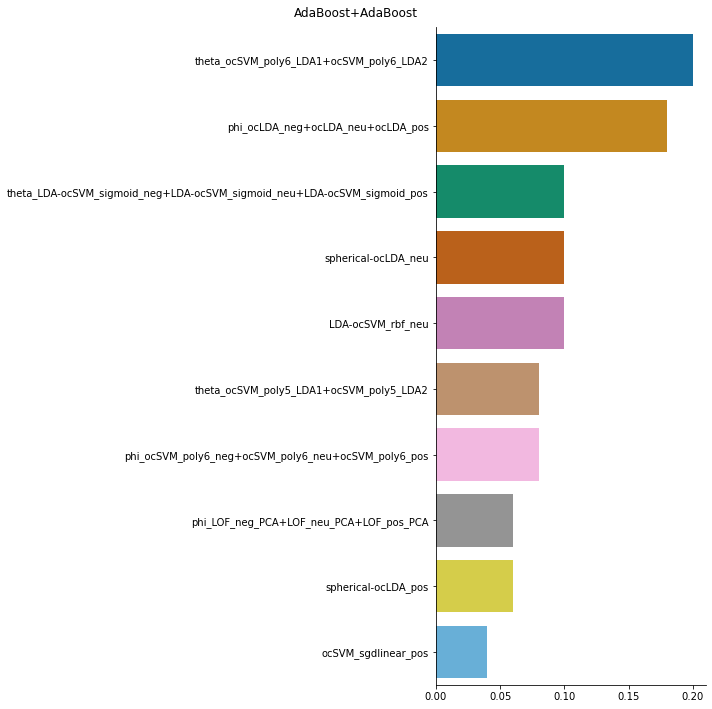

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(


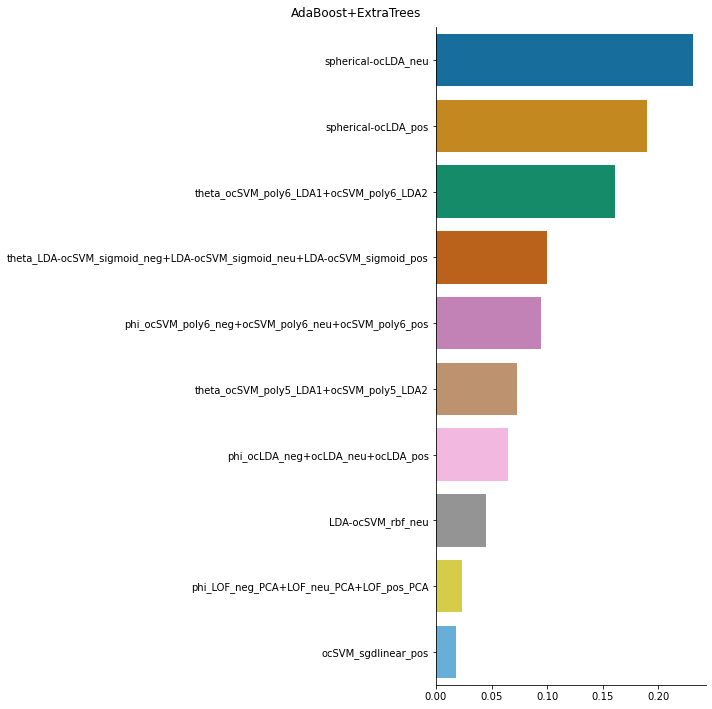

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


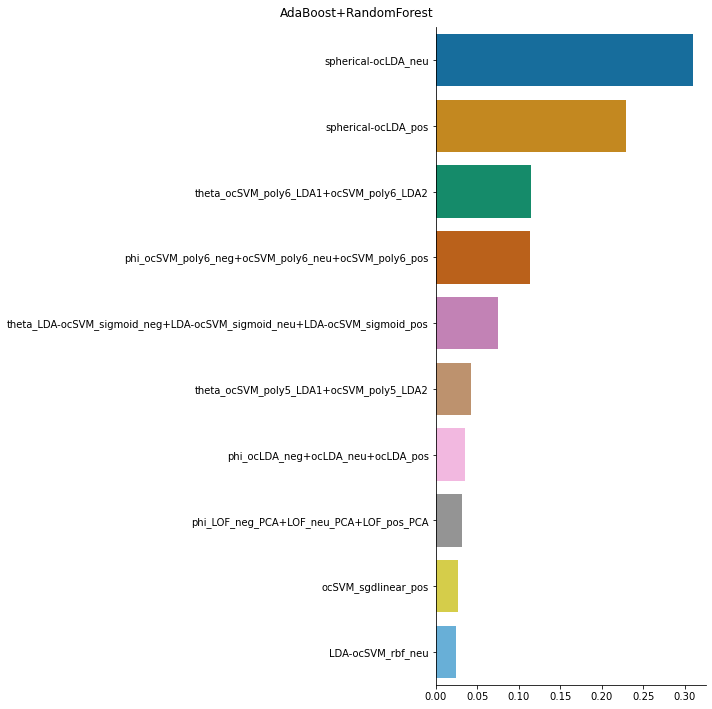

GaussianNB oob score changed by 0.1302 to 0.8270
extra trees oob score changed by -0.0051 to 0.8913
random forest oob score changed by -0.0140 to 0.9134

AdaBoost+AdaBoost
accuracy: 0.8522
roc_auc_ovo: 0.9423
log_loss: 1.0155
AdaBoost+ExtraTrees
accuracy: 0.9083
roc_auc_ovo: 0.9885
log_loss: 0.2490


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


AdaBoost+RandomForest
accuracy: 0.9696
roc_auc_ovo: 0.9985
log_loss: 0.1140
AdaBoost+GaussianNB
accuracy: 0.8271
roc_auc_ovo: 0.9593
log_loss: 0.7292

with feature selection by AdaBoost...
AdaBoost's accuracy changed by 0.0451 from 0.8072 to 0.8522
AdaBoost's roc_auc_ovo changed by 0.0362 from 0.9061 to 0.9423
AdaBoost's log_loss changed by 0.0052 from 1.0102 to 1.0155
ExtraTrees's accuracy changed by -0.0167 from 0.9250 to 0.9083
ExtraTrees's roc_auc_ovo changed by -0.0036 from 0.9921 to 0.9885
ExtraTrees's log_loss changed by 0.0073 from 0.2417 to 0.2490
RandomForest's accuracy changed by -0.0178 from 0.9874 to 0.9696
RandomForest's roc_auc_ovo changed by -0.0012 from 0.9997 to 0.9985
RandomForest's log_loss changed by 0.0285 from 0.0855 to 0.1140
GaussianNB's accuracy changed by 0.1299 from 0.6972 to 0.8271
GaussianNB's roc_auc_ovo changed by 0.0770 from 0.8823 to 0.9593
GaussianNB's log_loss changed by -0.9201 from 1.6493 to 0.7292

selecting with ExtraTrees


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


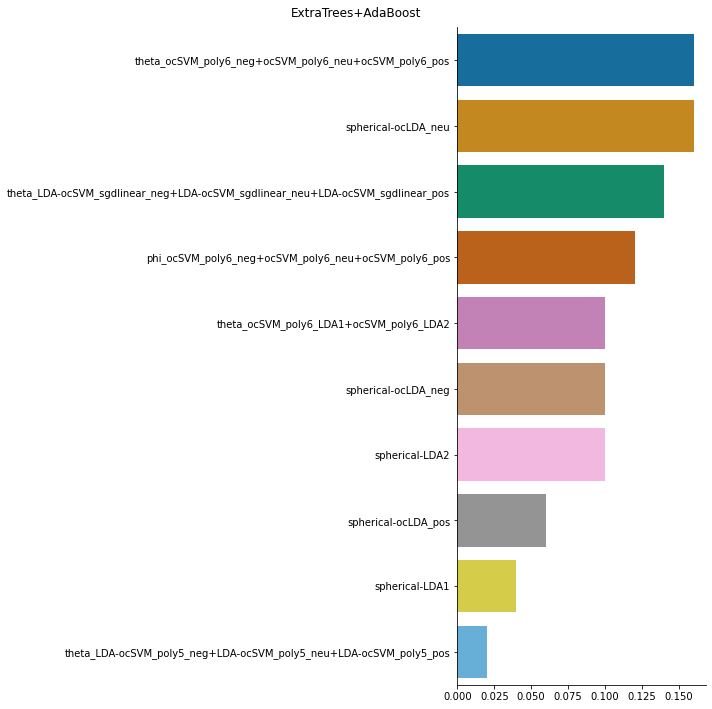

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(


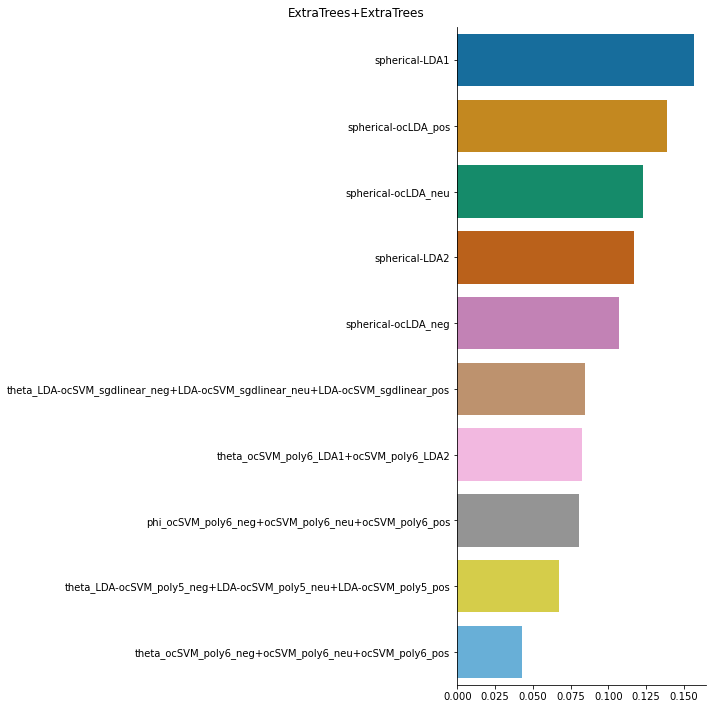

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


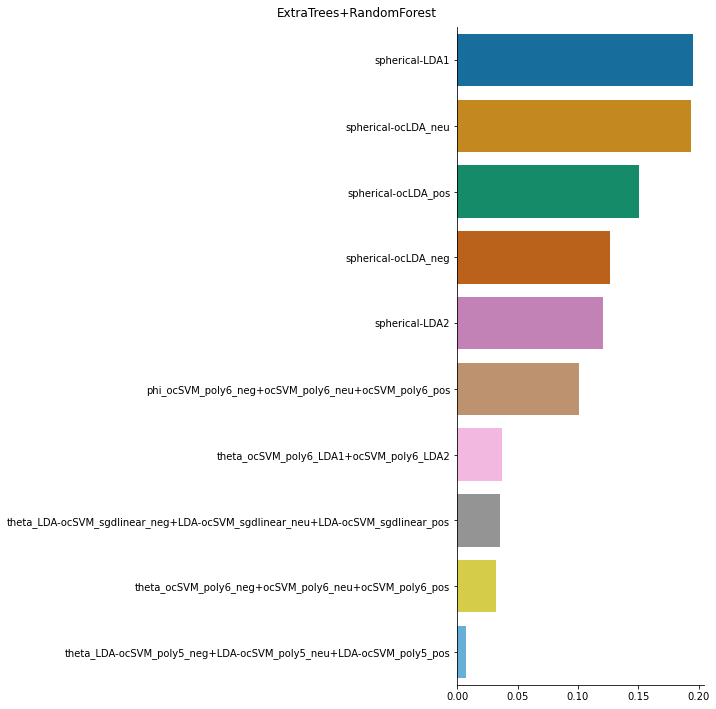

GaussianNB oob score changed by 0.1731 to 0.8700
extra trees oob score changed by -0.0100 to 0.8864
random forest oob score changed by -0.0260 to 0.9015

ExtraTrees+AdaBoost
accuracy: 0.8551
roc_auc_ovo: 0.9198
log_loss: 0.9142
ExtraTrees+ExtraTrees
accuracy: 0.8986
roc_auc_ovo: 0.9857
log_loss: 0.2453


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


ExtraTrees+RandomForest
accuracy: 0.9552
roc_auc_ovo: 0.9972
log_loss: 0.1327
ExtraTrees+GaussianNB
accuracy: 0.8700
roc_auc_ovo: 0.9687
log_loss: 0.9094

with feature selection by ExtraTrees...
AdaBoost's accuracy changed by 0.0479 from 0.8072 to 0.8551
AdaBoost's roc_auc_ovo changed by 0.0136 from 0.9061 to 0.9198
AdaBoost's log_loss changed by -0.0961 from 1.0102 to 0.9142
ExtraTrees's accuracy changed by -0.0264 from 0.9250 to 0.8986
ExtraTrees's roc_auc_ovo changed by -0.0064 from 0.9921 to 0.9857
ExtraTrees's log_loss changed by 0.0036 from 0.2417 to 0.2453
RandomForest's accuracy changed by -0.0322 from 0.9874 to 0.9552
RandomForest's roc_auc_ovo changed by -0.0025 from 0.9997 to 0.9972
RandomForest's log_loss changed by 0.0472 from 0.0855 to 0.1327
GaussianNB's accuracy changed by 0.1729 from 0.6972 to 0.8700
GaussianNB's roc_auc_ovo changed by 0.0863 from 0.8823 to 0.9687
GaussianNB's log_loss changed by -0.7399 from 1.6493 to 0.9094

selecting with RandomForest


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


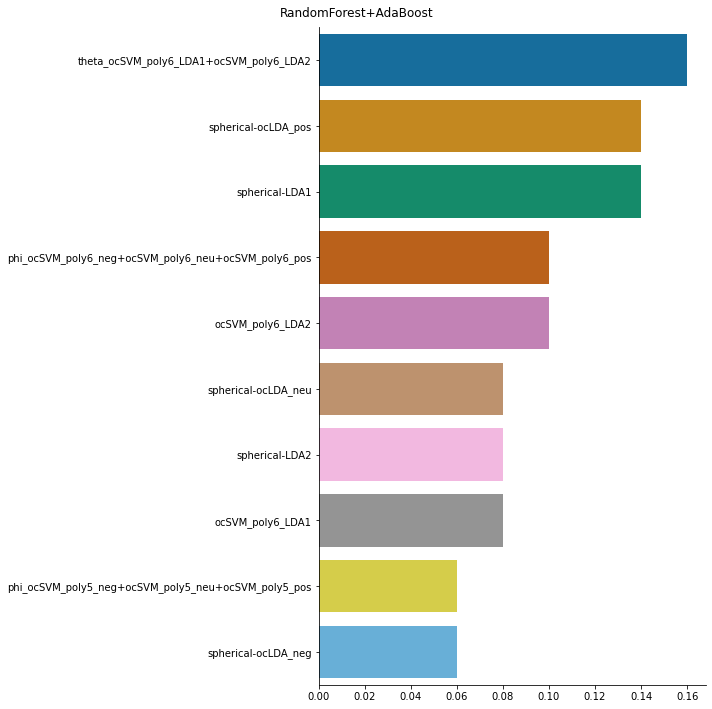

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(


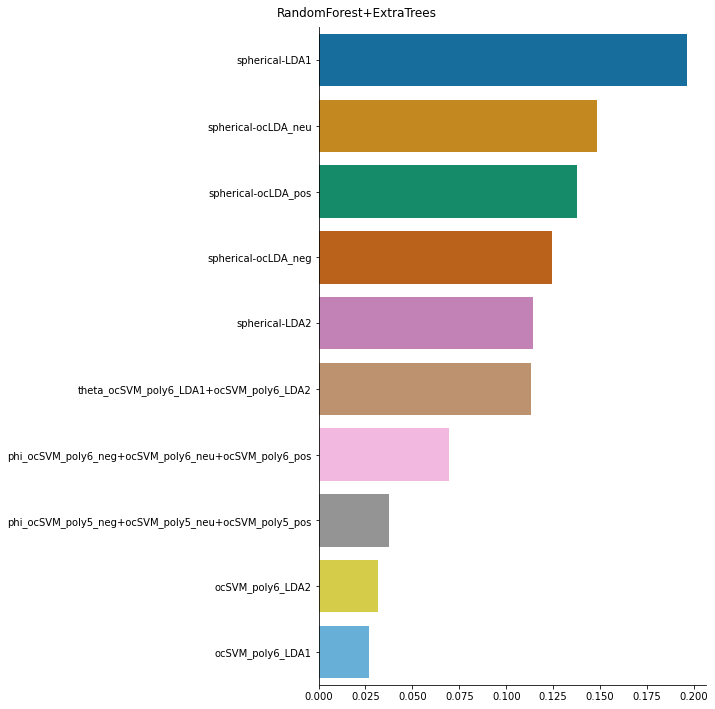

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


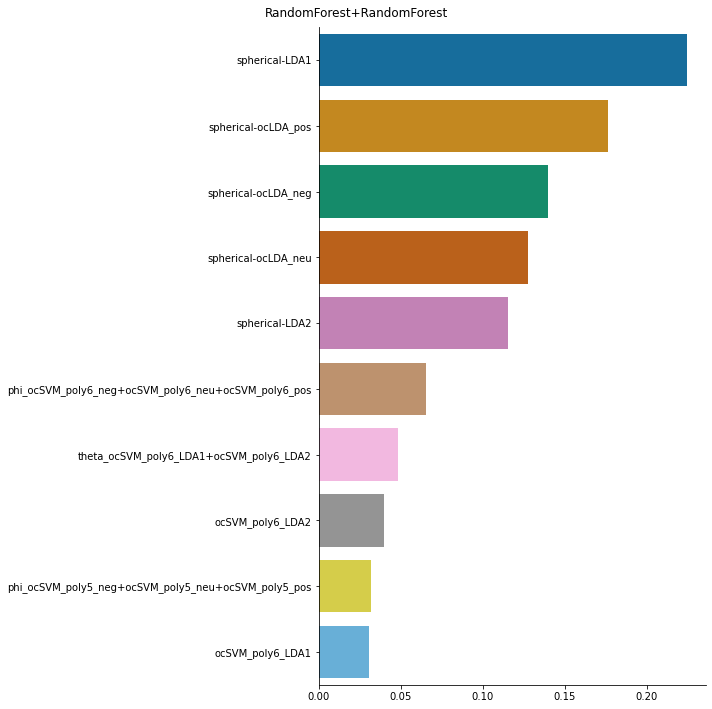

GaussianNB oob score changed by 0.1860 to 0.8829
extra trees oob score changed by -0.0089 to 0.8875
random forest oob score changed by -0.0274 to 0.9001

RandomForest+AdaBoost
accuracy: 0.8736
roc_auc_ovo: 0.9340
log_loss: 0.9970
RandomForest+ExtraTrees
accuracy: 0.9016
roc_auc_ovo: 0.9865
log_loss: 0.2409


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


RandomForest+RandomForest
accuracy: 0.9619
roc_auc_ovo: 0.9978
log_loss: 0.1284
RandomForest+GaussianNB
accuracy: 0.8829
roc_auc_ovo: 0.9698
log_loss: 0.8072

with feature selection by RandomForest...
AdaBoost's accuracy changed by 0.0664 from 0.8072 to 0.8736
AdaBoost's roc_auc_ovo changed by 0.0279 from 0.9061 to 0.9340
AdaBoost's log_loss changed by -0.0133 from 1.0102 to 0.9970
ExtraTrees's accuracy changed by -0.0235 from 0.9250 to 0.9016
ExtraTrees's roc_auc_ovo changed by -0.0056 from 0.9921 to 0.9865
ExtraTrees's log_loss changed by -0.0007 from 0.2417 to 0.2409
RandomForest's accuracy changed by -0.0255 from 0.9874 to 0.9619
RandomForest's roc_auc_ovo changed by -0.0019 from 0.9997 to 0.9978
RandomForest's log_loss changed by 0.0428 from 0.0855 to 0.1284
GaussianNB's accuracy changed by 0.1857 from 0.6972 to 0.8829
GaussianNB's roc_auc_ovo changed by 0.0875 from 0.8823 to 0.9698
GaussianNB's log_loss changed by -0.8421 from 1.6493 to 0.8072

time: 1min 58s


In [16]:
data = load_data(unscaled=True)
fitted_trees = fit_trees(data, y_true)
selectors = {
    model_name: SelectFromModel(estimator=fitted_model, prefit=True, max_features=10)
    for model_name, fitted_model in fitted_trees.items()
}
for selector_estimator, selector in selectors.items():
    print(f"selecting with {selector_estimator}")

    data_ = pd.DataFrame(
        selector.transform(data), columns=selector.get_feature_names_out(data.columns)
    )
    fitted_models: Dict[str, BaseEstimator] = {}

    for ensemble_name, fitted_tree in deepcopy(fitted_trees).items():
        fitted_models[
            f"{selector_estimator}+{ensemble_name}"
        ] = fitted_tree.fit(  # re-fit
            data_, y_true
        )
        plot_importances(
            fitted_tree, fig_height=10, title=f"{selector_estimator}+{ensemble_name}"
        )
    fitted_models[f"{selector_estimator}+GaussianNB"] = make_gnb().fit(data_, y_true)
    print(
        f"GaussianNB oob score changed by {(_ := fitted_models[f'{selector_estimator}+GaussianNB'].oob_score_) - oob_gnb:.4f} to {_:.4f}"
    )
    print(
        f"extra trees oob score changed by {(_ := fitted_models[f'{selector_estimator}+ExtraTrees'].oob_score_) - oob_extra:.4f} to {_:.4f}"
    )
    print(
        f"random forest oob score changed by {(_ := fitted_models[f'{selector_estimator}+RandomForest'].oob_score_) - oob_rf:.4f} to {_:.4f}"
    )
    print()

    scores_after: Dict[str, Dict[str, float]] = {
        k: score_model(v, k, data=data_) for k, v in fitted_models.items()
    }

    print(f"\nwith feature selection by {selector_estimator}...")
    for after_model, after_score_dict in scores_before.items():
        after_scores: Dict[str, float] = scores_after[
            f"{selector_estimator}+{after_model}"
        ]
        before_scores: Dict[str, float] = scores_before[after_model]
        base_model = after_model.split("+")[-1]
        for scorer, score in after_scores.items():
            print(
                f"{base_model}'s {scorer} changed by {(after := after_scores[scorer]) - (before := before_scores[scorer]):.4f} from {before:.4f} to {after:.4f}"
            )
    print()

and with max 8

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


selecting with AdaBoost


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


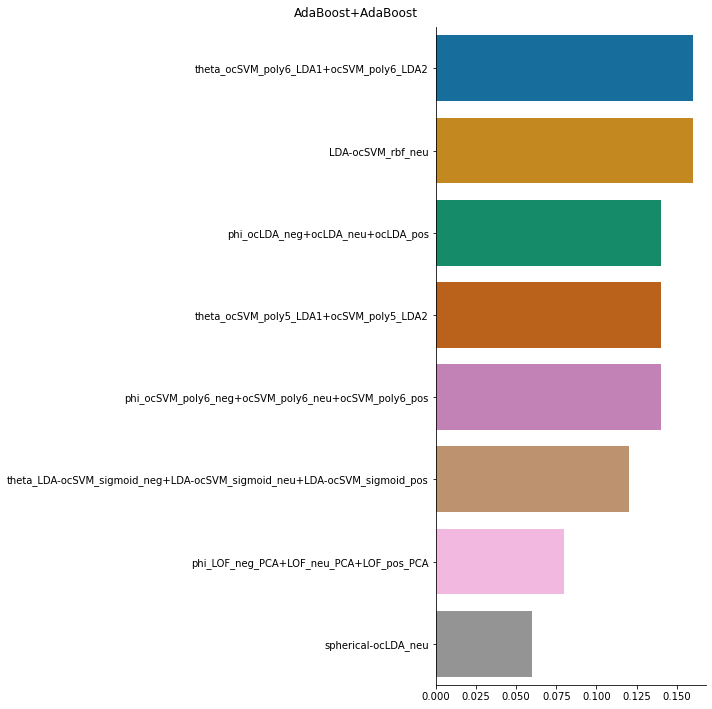

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(


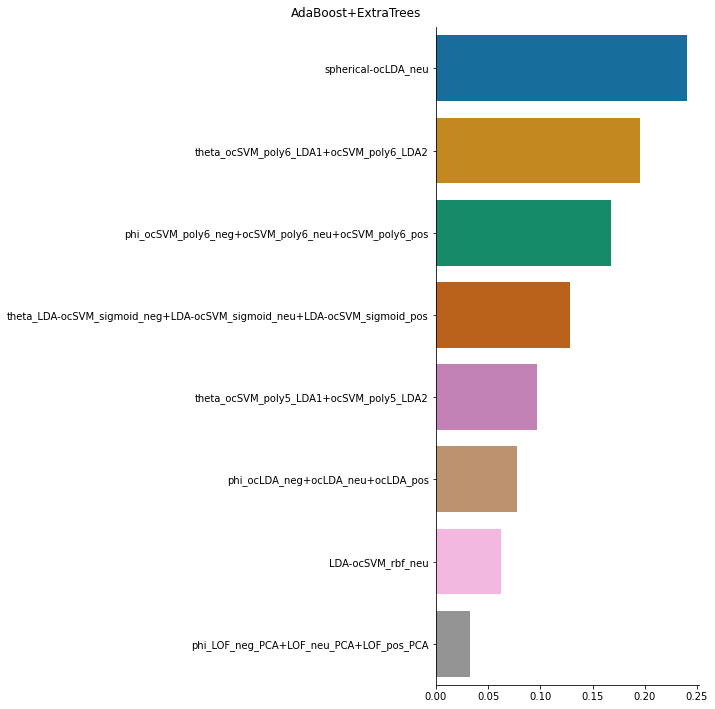

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


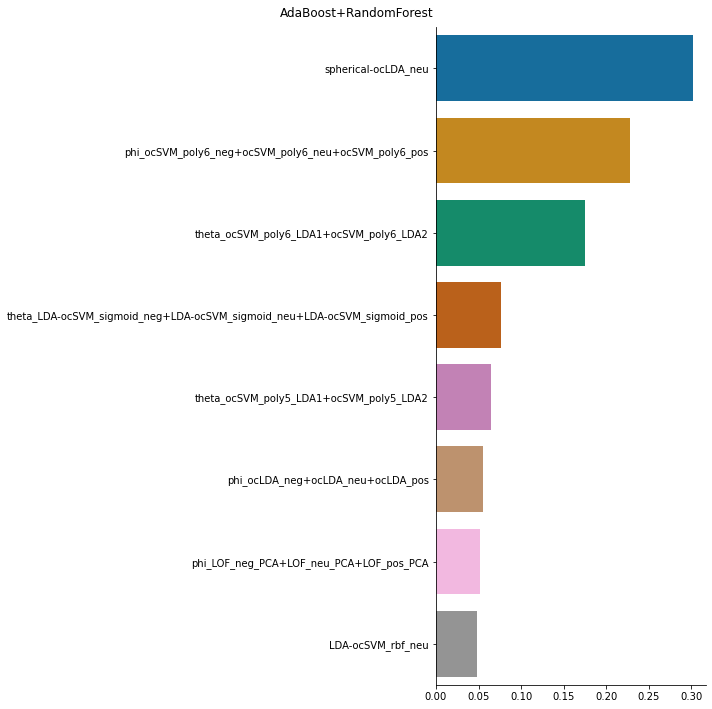

GaussianNB oob score changed by 0.1183 to 0.8151
extra trees oob score changed by -0.0278 to 0.8686
random forest oob score changed by -0.0262 to 0.9012

AdaBoost+AdaBoost
accuracy: 0.8085
roc_auc_ovo: 0.9008
log_loss: 1.0316
AdaBoost+ExtraTrees
accuracy: 0.8861
roc_auc_ovo: 0.9819
log_loss: 0.3092


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


AdaBoost+RandomForest
accuracy: 0.9604
roc_auc_ovo: 0.9975
log_loss: 0.1384
AdaBoost+GaussianNB
accuracy: 0.8152
roc_auc_ovo: 0.9536
log_loss: 0.6762

with feature selection by AdaBoost...
AdaBoost's accuracy changed by 0.0013 from 0.8072 to 0.8085
AdaBoost's roc_auc_ovo changed by -0.0054 from 0.9061 to 0.9008
AdaBoost's log_loss changed by 0.0213 from 1.0102 to 1.0316
ExtraTrees's accuracy changed by -0.0390 from 0.9250 to 0.8861
ExtraTrees's roc_auc_ovo changed by -0.0102 from 0.9921 to 0.9819
ExtraTrees's log_loss changed by 0.0675 from 0.2417 to 0.3092
RandomForest's accuracy changed by -0.0270 from 0.9874 to 0.9604
RandomForest's roc_auc_ovo changed by -0.0022 from 0.9997 to 0.9975
RandomForest's log_loss changed by 0.0529 from 0.0855 to 0.1384
GaussianNB's accuracy changed by 0.1180 from 0.6972 to 0.8152
GaussianNB's roc_auc_ovo changed by 0.0713 from 0.8823 to 0.9536
GaussianNB's log_loss changed by -0.9731 from 1.6493 to 0.6762

selecting with ExtraTrees


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


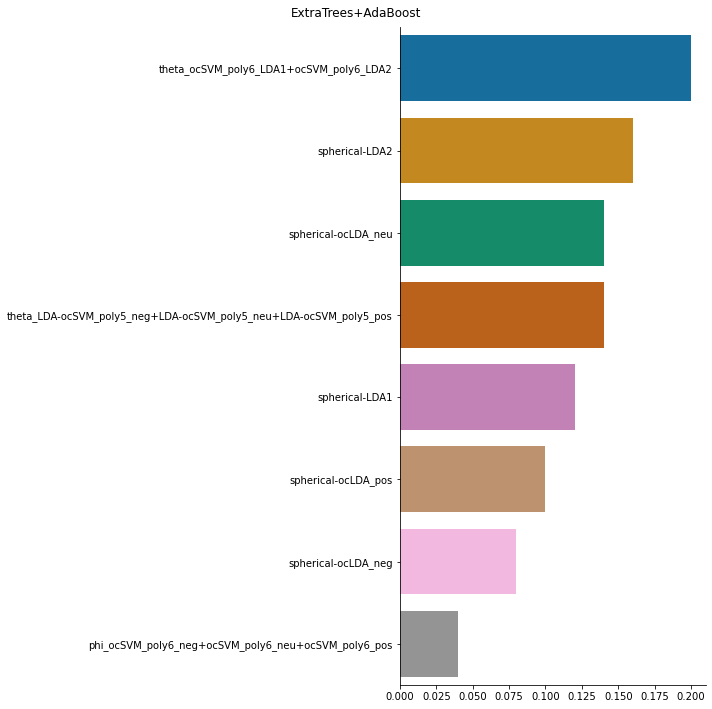

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(


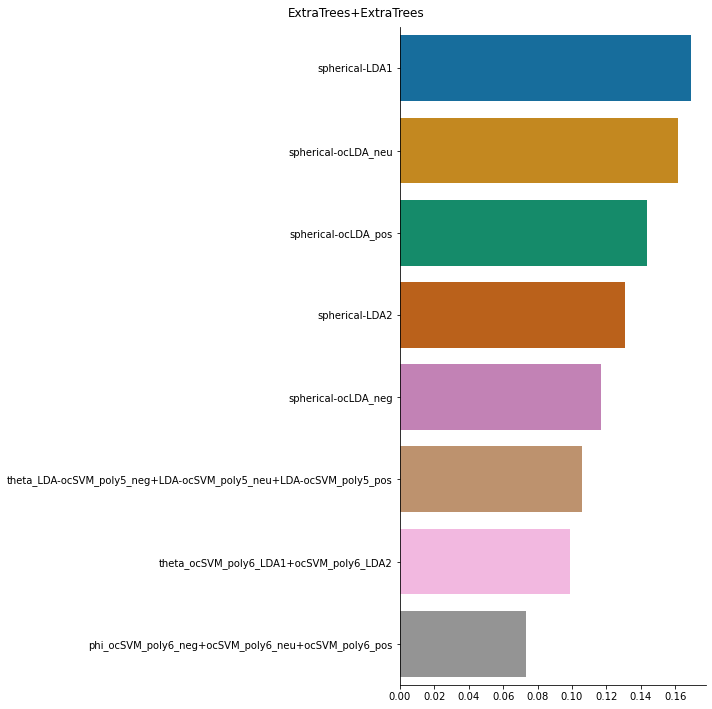

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


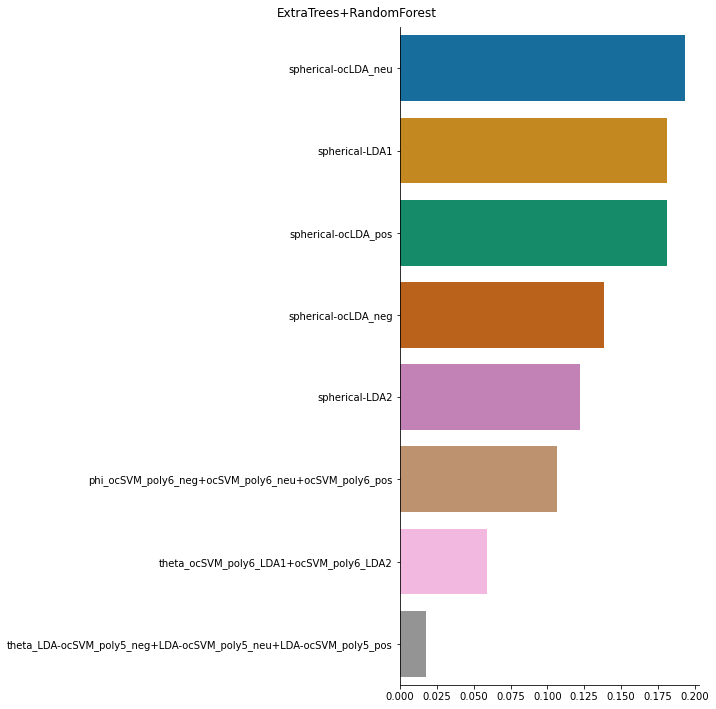

GaussianNB oob score changed by 0.1820 to 0.8788
extra trees oob score changed by -0.0135 to 0.8830
random forest oob score changed by -0.0340 to 0.8935

ExtraTrees+AdaBoost
accuracy: 0.8382
roc_auc_ovo: 0.9074
log_loss: 0.9746
ExtraTrees+ExtraTrees
accuracy: 0.8930
roc_auc_ovo: 0.9836
log_loss: 0.2618


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


ExtraTrees+RandomForest
accuracy: 0.9452
roc_auc_ovo: 0.9959
log_loss: 0.1514
ExtraTrees+GaussianNB
accuracy: 0.8788
roc_auc_ovo: 0.9708
log_loss: 0.7492

with feature selection by ExtraTrees...
AdaBoost's accuracy changed by 0.0310 from 0.8072 to 0.8382
AdaBoost's roc_auc_ovo changed by 0.0013 from 0.9061 to 0.9074
AdaBoost's log_loss changed by -0.0356 from 1.0102 to 0.9746
ExtraTrees's accuracy changed by -0.0320 from 0.9250 to 0.8930
ExtraTrees's roc_auc_ovo changed by -0.0085 from 0.9921 to 0.9836
ExtraTrees's log_loss changed by 0.0201 from 0.2417 to 0.2618
RandomForest's accuracy changed by -0.0422 from 0.9874 to 0.9452
RandomForest's roc_auc_ovo changed by -0.0038 from 0.9997 to 0.9959
RandomForest's log_loss changed by 0.0658 from 0.0855 to 0.1514
GaussianNB's accuracy changed by 0.1816 from 0.6972 to 0.8788
GaussianNB's roc_auc_ovo changed by 0.0884 from 0.8823 to 0.9708
GaussianNB's log_loss changed by -0.9001 from 1.6493 to 0.7492

selecting with RandomForest


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


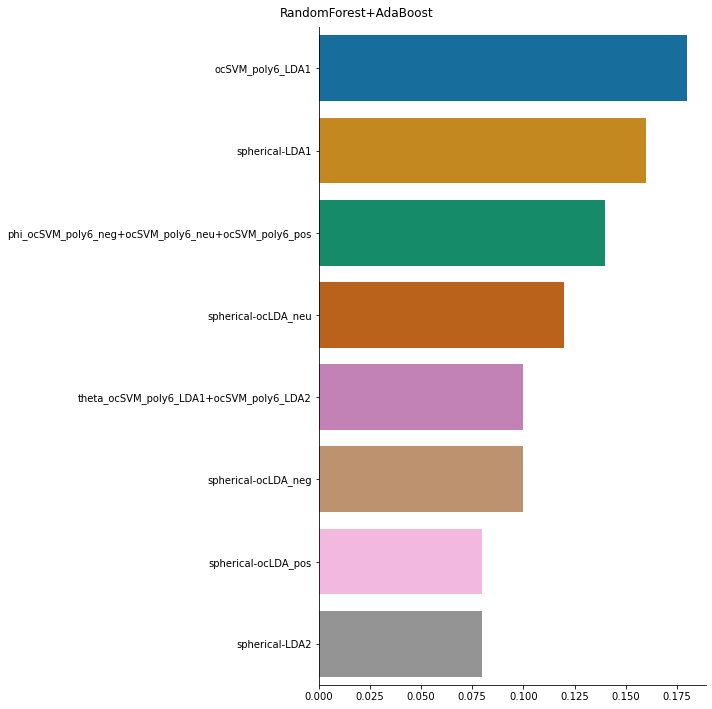

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(


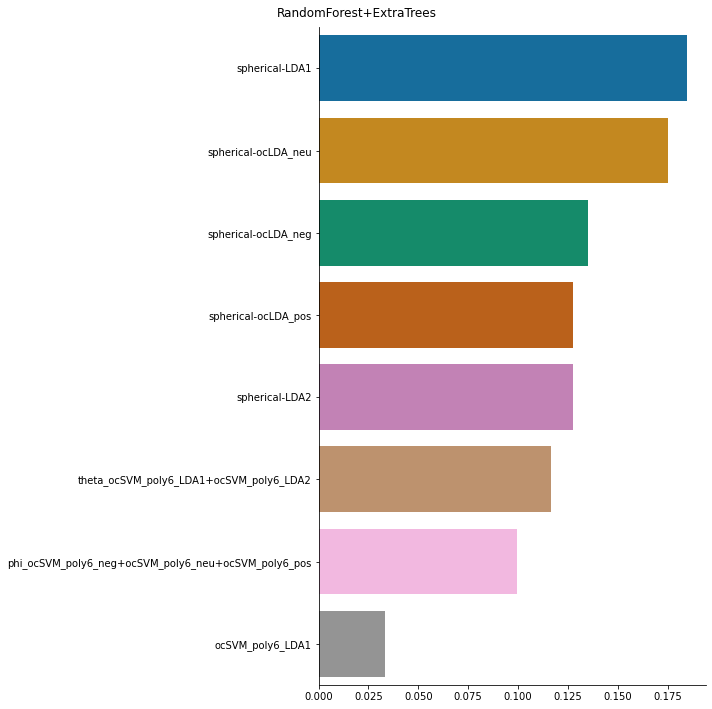

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


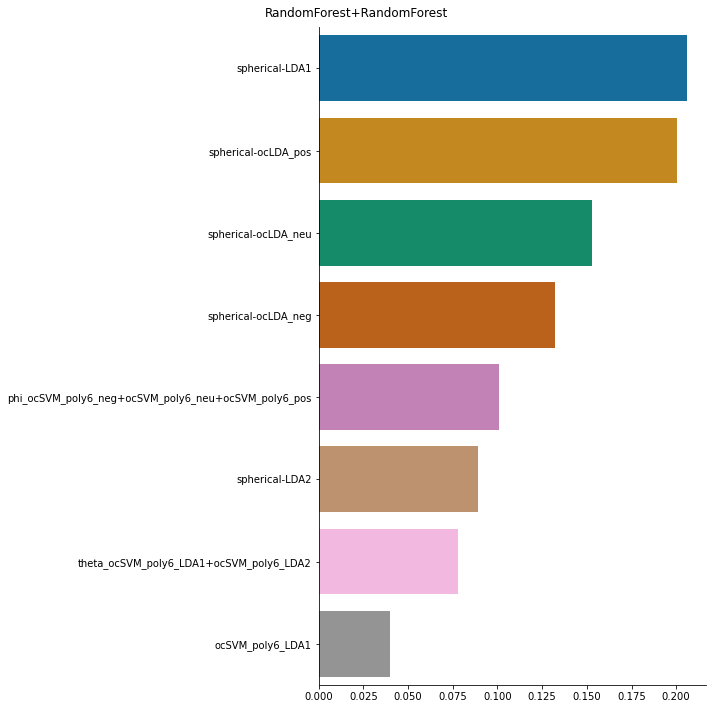

GaussianNB oob score changed by 0.1891 to 0.8859
extra trees oob score changed by -0.0140 to 0.8824
random forest oob score changed by -0.0354 to 0.8921

RandomForest+AdaBoost
accuracy: 0.8658
roc_auc_ovo: 0.8802
log_loss: 0.9618
RandomForest+ExtraTrees
accuracy: 0.8925
roc_auc_ovo: 0.9836
log_loss: 0.2627


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


RandomForest+RandomForest
accuracy: 0.9514
roc_auc_ovo: 0.9966
log_loss: 0.1448
RandomForest+GaussianNB
accuracy: 0.8860
roc_auc_ovo: 0.9716
log_loss: 0.6953

with feature selection by RandomForest...
AdaBoost's accuracy changed by 0.0586 from 0.8072 to 0.8658
AdaBoost's roc_auc_ovo changed by -0.0259 from 0.9061 to 0.8802
AdaBoost's log_loss changed by -0.0485 from 1.0102 to 0.9618
ExtraTrees's accuracy changed by -0.0325 from 0.9250 to 0.8925
ExtraTrees's roc_auc_ovo changed by -0.0085 from 0.9921 to 0.9836
ExtraTrees's log_loss changed by 0.0210 from 0.2417 to 0.2627
RandomForest's accuracy changed by -0.0361 from 0.9874 to 0.9514
RandomForest's roc_auc_ovo changed by -0.0031 from 0.9997 to 0.9966
RandomForest's log_loss changed by 0.0593 from 0.0855 to 0.1448
GaussianNB's accuracy changed by 0.1888 from 0.6972 to 0.8860
GaussianNB's roc_auc_ovo changed by 0.0892 from 0.8823 to 0.9716
GaussianNB's log_loss changed by -0.9539 from 1.6493 to 0.6953

time: 1min 41s


In [17]:
data = load_data(unscaled=True)
fitted_trees = fit_trees(data, y_true)
selectors = {
    model_name: SelectFromModel(estimator=fitted_model, prefit=True, max_features=8)
    for model_name, fitted_model in fitted_trees.items()
}
for selector_estimator, selector in selectors.items():
    print(f"selecting with {selector_estimator}")

    data_ = pd.DataFrame(
        selector.transform(data), columns=selector.get_feature_names_out(data.columns)
    )
    fitted_models: Dict[str, BaseEstimator] = {}

    for ensemble_name, fitted_tree in deepcopy(fitted_trees).items():
        fitted_models[
            f"{selector_estimator}+{ensemble_name}"
        ] = fitted_tree.fit(  # re-fit
            data_, y_true
        )
        plot_importances(
            fitted_tree, fig_height=10, title=f"{selector_estimator}+{ensemble_name}"
        )
    fitted_models[f"{selector_estimator}+GaussianNB"] = make_gnb().fit(data_, y_true)
    print(
        f"GaussianNB oob score changed by {(_ := fitted_models[f'{selector_estimator}+GaussianNB'].oob_score_) - oob_gnb:.4f} to {_:.4f}"
    )
    print(
        f"extra trees oob score changed by {(_ := fitted_models[f'{selector_estimator}+ExtraTrees'].oob_score_) - oob_extra:.4f} to {_:.4f}"
    )
    print(
        f"random forest oob score changed by {(_ := fitted_models[f'{selector_estimator}+RandomForest'].oob_score_) - oob_rf:.4f} to {_:.4f}"
    )
    print()

    scores_after: Dict[str, Dict[str, float]] = {
        k: score_model(v, k, data=data_) for k, v in fitted_models.items()
    }

    print(f"\nwith feature selection by {selector_estimator}...")
    for after_model, after_score_dict in scores_before.items():
        after_scores: Dict[str, float] = scores_after[
            f"{selector_estimator}+{after_model}"
        ]
        before_scores: Dict[str, float] = scores_before[after_model]
        base_model = after_model.split("+")[-1]
        for scorer, score in after_scores.items():
            print(
                f"{base_model}'s {scorer} changed by {(after := after_scores[scorer]) - (before := before_scores[scorer]):.4f} from {before:.4f} to {after:.4f}"
            )
    print()

with SelectKBest

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


selecting with SelectKBest_1


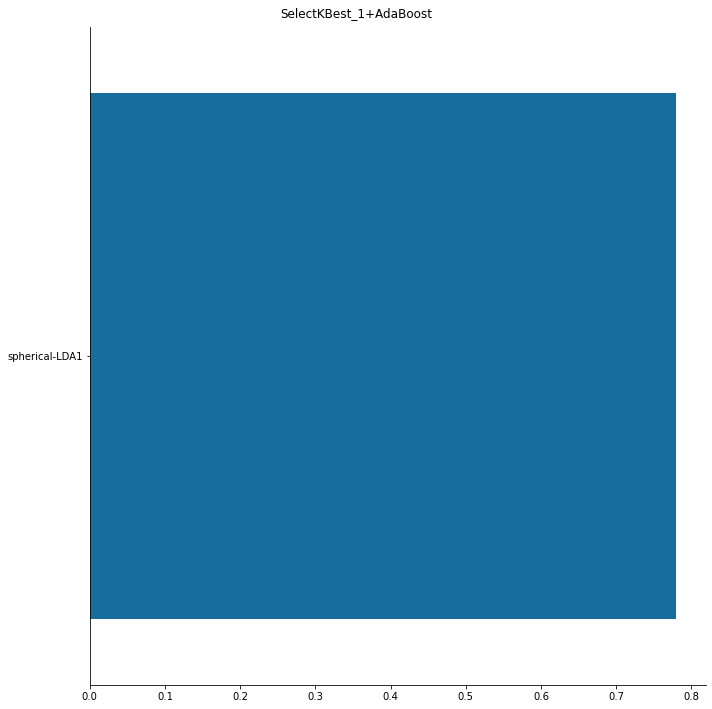

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(


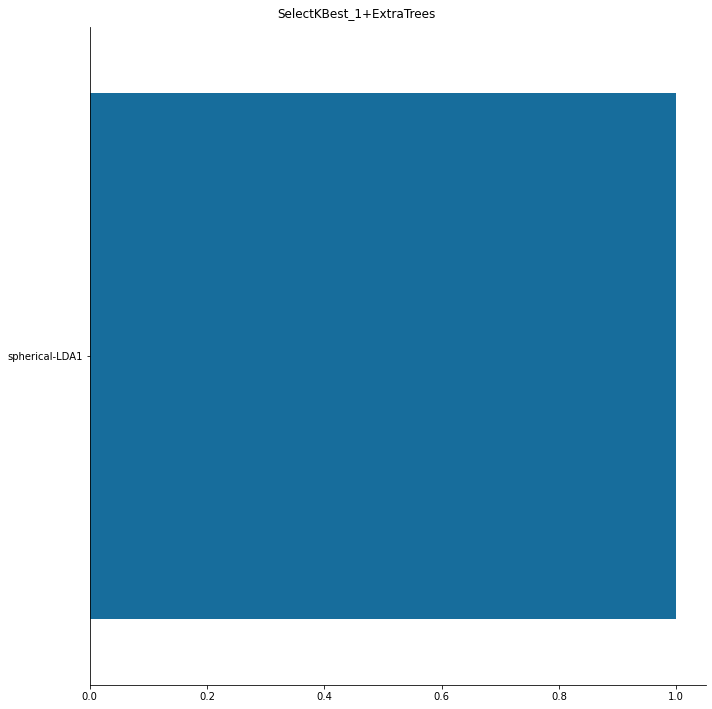

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


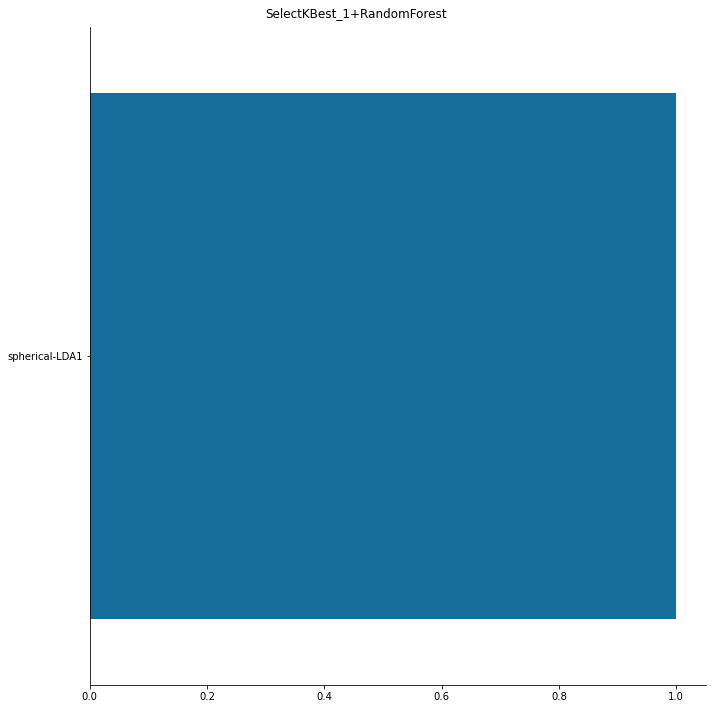

GaussianNB oob score changed by 0.1075 to 0.8043
extra trees oob score changed by -0.1007 to 0.7958
random forest oob score changed by -0.1338 to 0.7936

SelectKBest_1+AdaBoost
accuracy: 0.8064
roc_auc_ovo: 0.8165
log_loss: 1.0025
SelectKBest_1+ExtraTrees
accuracy: 0.8075
roc_auc_ovo: 0.9313
log_loss: 0.4786


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


SelectKBest_1+RandomForest
accuracy: 0.8223
roc_auc_ovo: 0.9455
log_loss: 0.4397
SelectKBest_1+GaussianNB
accuracy: 0.8044
roc_auc_ovo: 0.9021
log_loss: 0.5234

with feature selection by SelectKBest_1...
AdaBoost's accuracy changed by -0.0007 from 0.8072 to 0.8064
AdaBoost's roc_auc_ovo changed by -0.0897 from 0.9061 to 0.8165
AdaBoost's log_loss changed by -0.0078 from 1.0102 to 1.0025
ExtraTrees's accuracy changed by -0.1175 from 0.9250 to 0.8075
ExtraTrees's roc_auc_ovo changed by -0.0608 from 0.9921 to 0.9313
ExtraTrees's log_loss changed by 0.2370 from 0.2417 to 0.4786
RandomForest's accuracy changed by -0.1651 from 0.9874 to 0.8223
RandomForest's roc_auc_ovo changed by -0.0542 from 0.9997 to 0.9455
RandomForest's log_loss changed by 0.3541 from 0.0855 to 0.4397
GaussianNB's accuracy changed by 0.1072 from 0.6972 to 0.8044
GaussianNB's roc_auc_ovo changed by 0.0198 from 0.8823 to 0.9021
GaussianNB's log_loss changed by -1.1259 from 1.6493 to 0.5234

selecting with SelectKBest_2


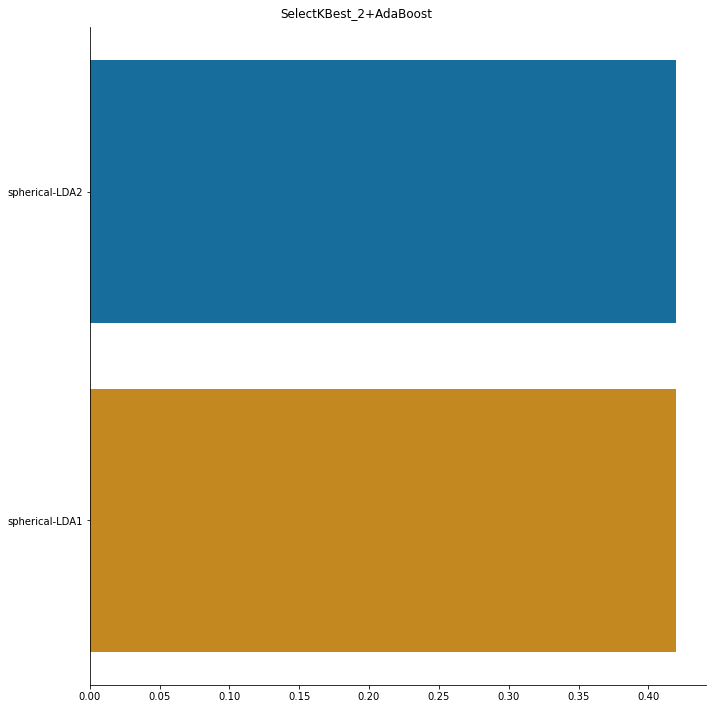

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(


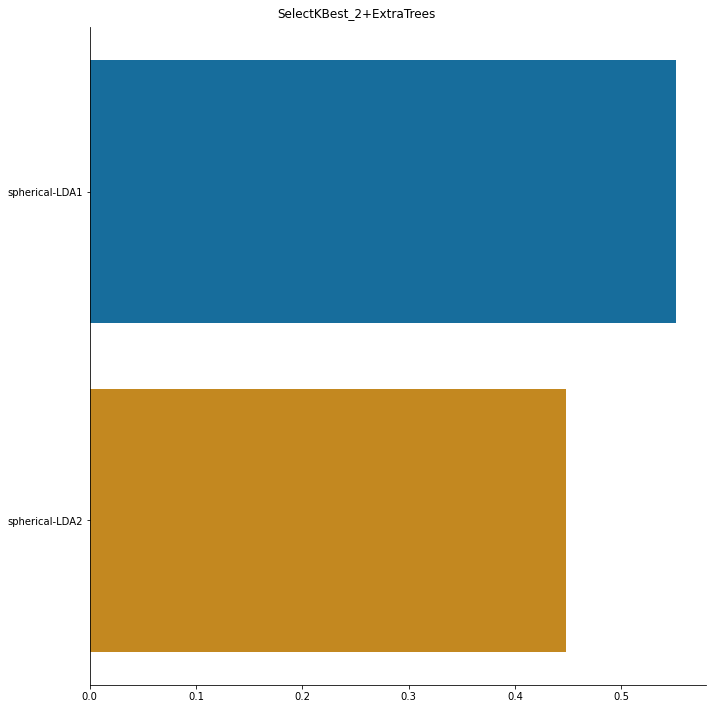

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


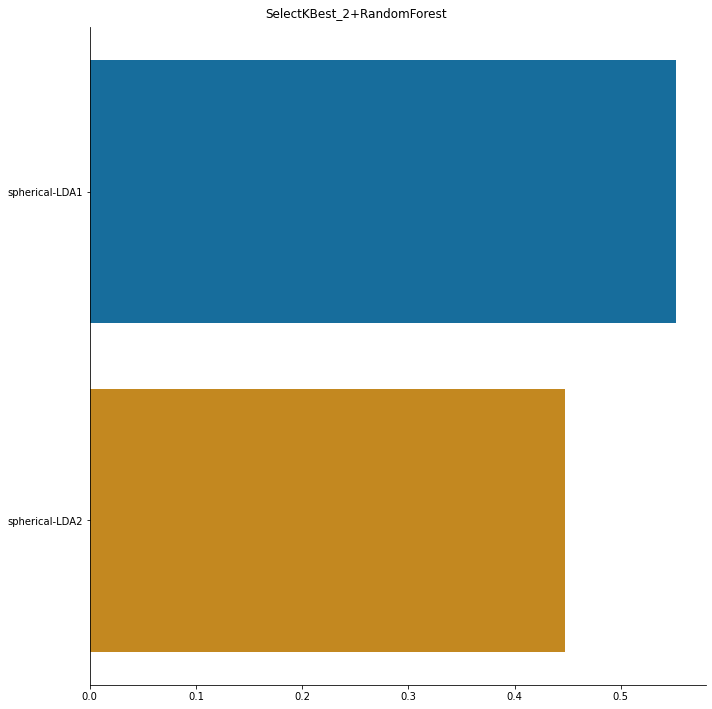

GaussianNB oob score changed by 0.1835 to 0.8804
extra trees oob score changed by -0.0236 to 0.8729
random forest oob score changed by -0.0513 to 0.8761

SelectKBest_2+AdaBoost
accuracy: 0.8641
roc_auc_ovo: 0.8947
log_loss: 0.9668
SelectKBest_2+ExtraTrees
accuracy: 0.8785
roc_auc_ovo: 0.9779
log_loss: 0.3045


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


SelectKBest_2+RandomForest
accuracy: 0.9207
roc_auc_ovo: 0.9916
log_loss: 0.1932
SelectKBest_2+GaussianNB
accuracy: 0.8804
roc_auc_ovo: 0.9695
log_loss: 0.3560

with feature selection by SelectKBest_2...
AdaBoost's accuracy changed by 0.0570 from 0.8072 to 0.8641
AdaBoost's roc_auc_ovo changed by -0.0114 from 0.9061 to 0.8947
AdaBoost's log_loss changed by -0.0435 from 1.0102 to 0.9668
ExtraTrees's accuracy changed by -0.0465 from 0.9250 to 0.8785
ExtraTrees's roc_auc_ovo changed by -0.0142 from 0.9921 to 0.9779
ExtraTrees's log_loss changed by 0.0628 from 0.2417 to 0.3045
RandomForest's accuracy changed by -0.0667 from 0.9874 to 0.9207
RandomForest's roc_auc_ovo changed by -0.0081 from 0.9997 to 0.9916
RandomForest's log_loss changed by 0.1076 from 0.0855 to 0.1932
GaussianNB's accuracy changed by 0.1832 from 0.6972 to 0.8804
GaussianNB's roc_auc_ovo changed by 0.0872 from 0.8823 to 0.9695
GaussianNB's log_loss changed by -1.2932 from 1.6493 to 0.3560

selecting with SelectKBest_3


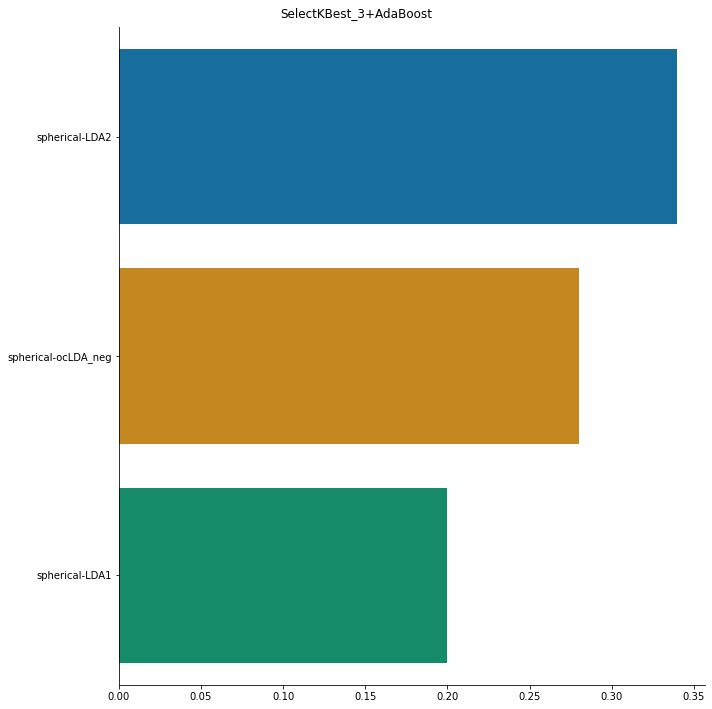

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(


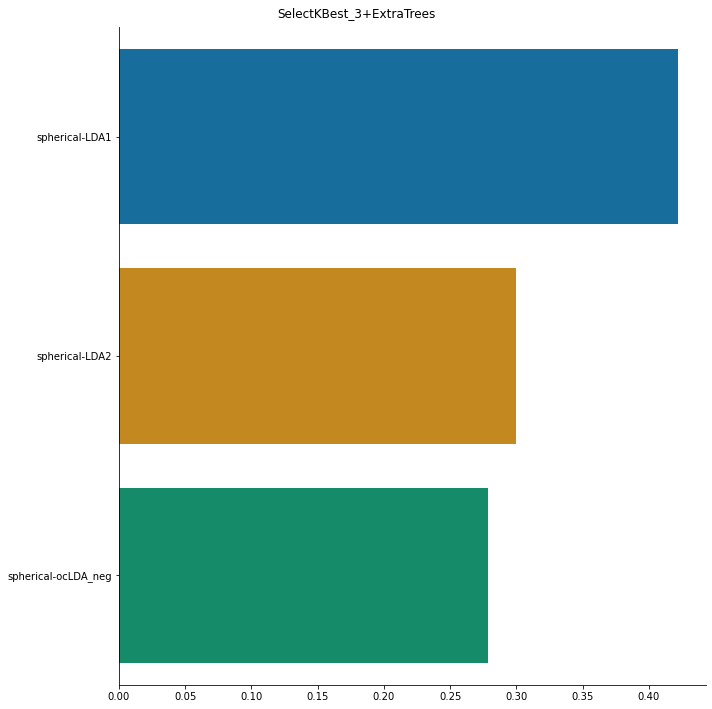

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


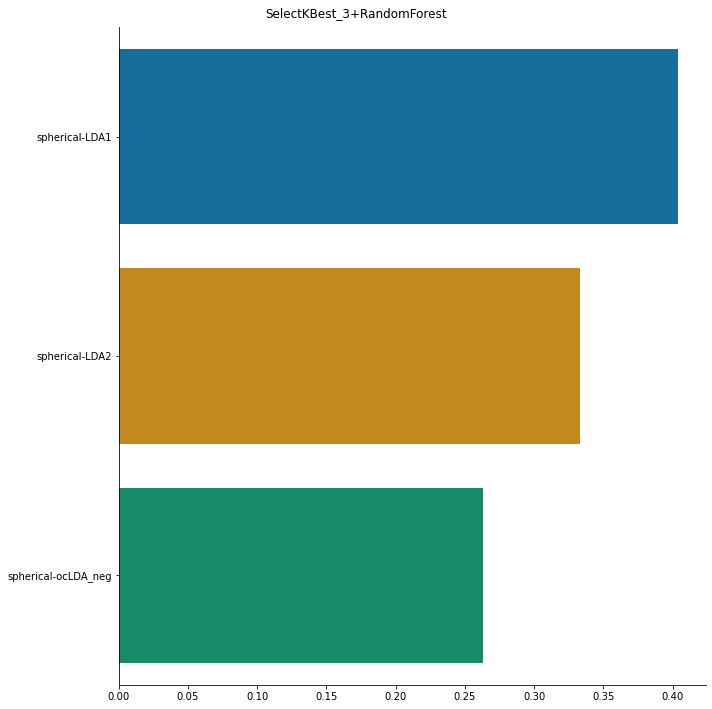

GaussianNB oob score changed by 0.1869 to 0.8838
extra trees oob score changed by -0.0217 to 0.8747
random forest oob score changed by -0.0506 to 0.8768

SelectKBest_3+AdaBoost
accuracy: 0.8397
roc_auc_ovo: 0.9084
log_loss: 0.9522
SelectKBest_3+ExtraTrees
accuracy: 0.8808
roc_auc_ovo: 0.9776
log_loss: 0.3030


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


SelectKBest_3+RandomForest
accuracy: 0.9246
roc_auc_ovo: 0.9924
log_loss: 0.1863
SelectKBest_3+GaussianNB
accuracy: 0.8838
roc_auc_ovo: 0.9683
log_loss: 0.4108

with feature selection by SelectKBest_3...
AdaBoost's accuracy changed by 0.0325 from 0.8072 to 0.8397
AdaBoost's roc_auc_ovo changed by 0.0023 from 0.9061 to 0.9084
AdaBoost's log_loss changed by -0.0580 from 1.0102 to 0.9522
ExtraTrees's accuracy changed by -0.0442 from 0.9250 to 0.8808
ExtraTrees's roc_auc_ovo changed by -0.0144 from 0.9921 to 0.9776
ExtraTrees's log_loss changed by 0.0613 from 0.2417 to 0.3030
RandomForest's accuracy changed by -0.0628 from 0.9874 to 0.9246
RandomForest's roc_auc_ovo changed by -0.0073 from 0.9997 to 0.9924
RandomForest's log_loss changed by 0.1008 from 0.0855 to 0.1863
GaussianNB's accuracy changed by 0.1866 from 0.6972 to 0.8838
GaussianNB's roc_auc_ovo changed by 0.0860 from 0.8823 to 0.9683
GaussianNB's log_loss changed by -1.2384 from 1.6493 to 0.4108

selecting with SelectKBest_4


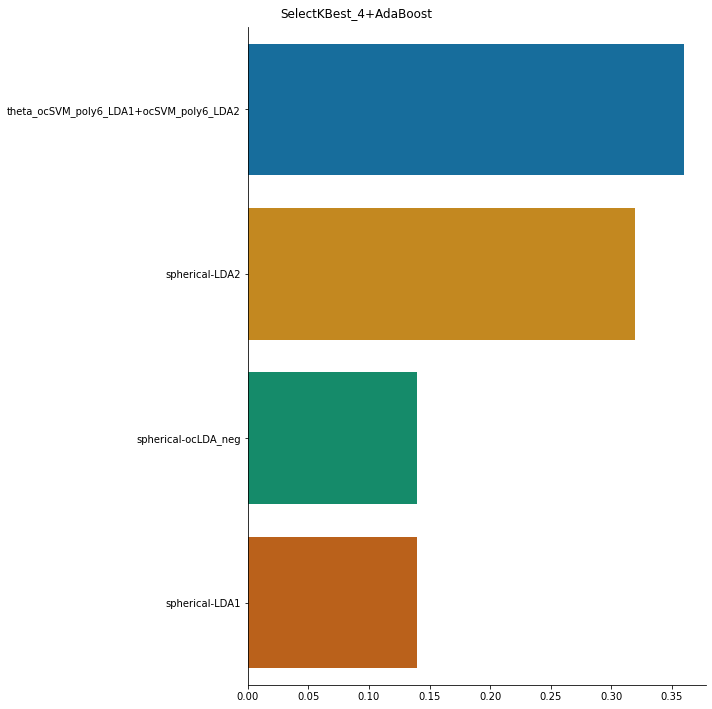

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(


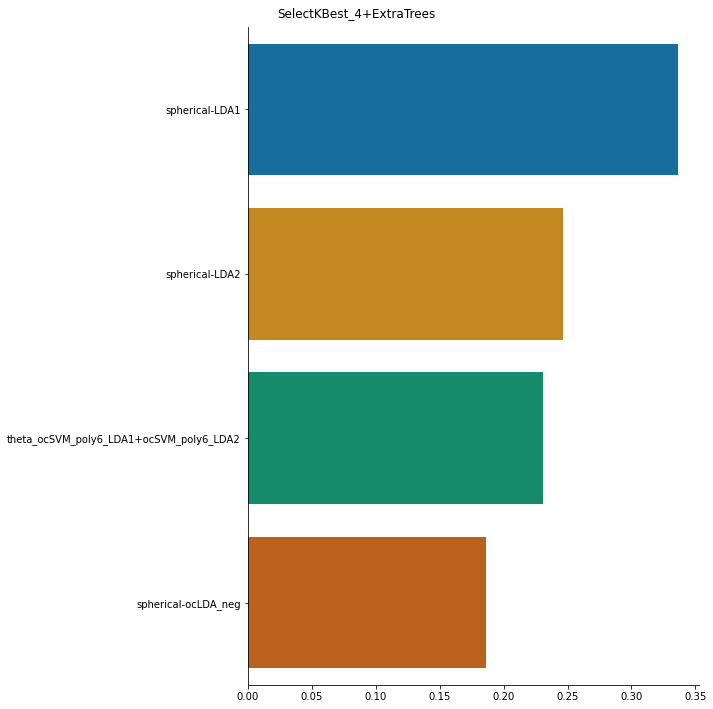

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


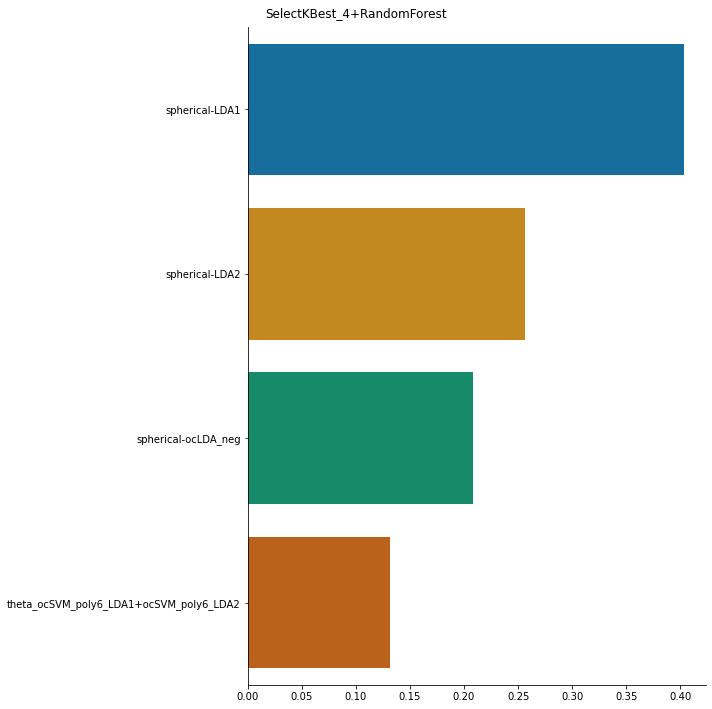

GaussianNB oob score changed by 0.1835 to 0.8803
extra trees oob score changed by -0.0171 to 0.8793
random forest oob score changed by -0.0438 to 0.8836

SelectKBest_4+AdaBoost
accuracy: 0.8610
roc_auc_ovo: 0.9330
log_loss: 1.0093
SelectKBest_4+ExtraTrees
accuracy: 0.8950
roc_auc_ovo: 0.9846
log_loss: 0.2528


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


SelectKBest_4+RandomForest
accuracy: 0.9407
roc_auc_ovo: 0.9954
log_loss: 0.1575
SelectKBest_4+GaussianNB
accuracy: 0.8802
roc_auc_ovo: 0.9681
log_loss: 0.4632

with feature selection by SelectKBest_4...
AdaBoost's accuracy changed by 0.0538 from 0.8072 to 0.8610
AdaBoost's roc_auc_ovo changed by 0.0269 from 0.9061 to 0.9330
AdaBoost's log_loss changed by -0.0009 from 1.0102 to 1.0093
ExtraTrees's accuracy changed by -0.0301 from 0.9250 to 0.8950
ExtraTrees's roc_auc_ovo changed by -0.0075 from 0.9921 to 0.9846
ExtraTrees's log_loss changed by 0.0111 from 0.2417 to 0.2528
RandomForest's accuracy changed by -0.0467 from 0.9874 to 0.9407
RandomForest's roc_auc_ovo changed by -0.0043 from 0.9997 to 0.9954
RandomForest's log_loss changed by 0.0720 from 0.0855 to 0.1575
GaussianNB's accuracy changed by 0.1831 from 0.6972 to 0.8802
GaussianNB's roc_auc_ovo changed by 0.0858 from 0.8823 to 0.9681
GaussianNB's log_loss changed by -1.1861 from 1.6493 to 0.4632

selecting with SelectKBest_5


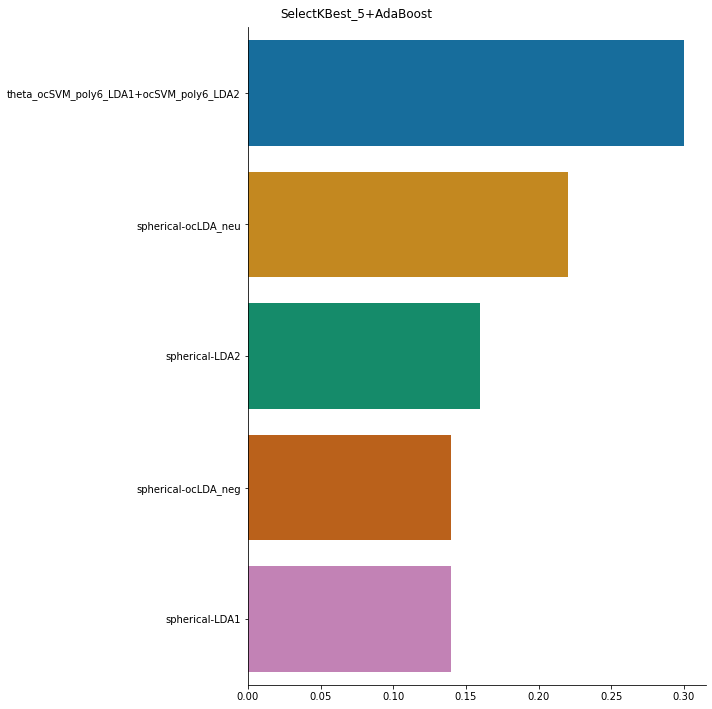

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(


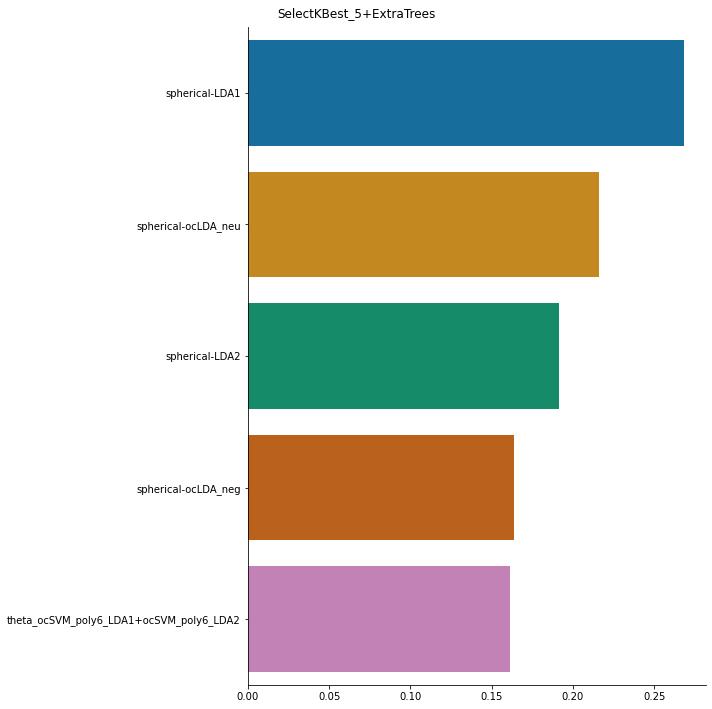

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


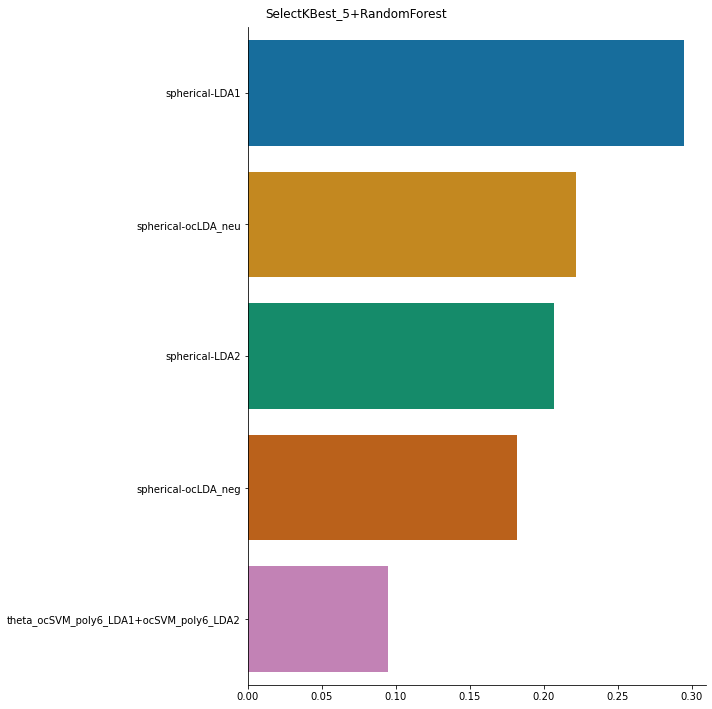

GaussianNB oob score changed by 0.1847 to 0.8815
extra trees oob score changed by -0.0182 to 0.8782
random forest oob score changed by -0.0443 to 0.8831

SelectKBest_5+AdaBoost
accuracy: 0.8645
roc_auc_ovo: 0.8618
log_loss: 0.9657
SelectKBest_5+ExtraTrees
accuracy: 0.8925
roc_auc_ovo: 0.9838
log_loss: 0.2573


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


SelectKBest_5+RandomForest
accuracy: 0.9394
roc_auc_ovo: 0.9952
log_loss: 0.1600
SelectKBest_5+GaussianNB
accuracy: 0.8816
roc_auc_ovo: 0.9691
log_loss: 0.5601

with feature selection by SelectKBest_5...
AdaBoost's accuracy changed by 0.0574 from 0.8072 to 0.8645
AdaBoost's roc_auc_ovo changed by -0.0443 from 0.9061 to 0.8618
AdaBoost's log_loss changed by -0.0446 from 1.0102 to 0.9657
ExtraTrees's accuracy changed by -0.0325 from 0.9250 to 0.8925
ExtraTrees's roc_auc_ovo changed by -0.0083 from 0.9921 to 0.9838
ExtraTrees's log_loss changed by 0.0156 from 0.2417 to 0.2573
RandomForest's accuracy changed by -0.0480 from 0.9874 to 0.9394
RandomForest's roc_auc_ovo changed by -0.0045 from 0.9997 to 0.9952
RandomForest's log_loss changed by 0.0744 from 0.0855 to 0.1600
GaussianNB's accuracy changed by 0.1844 from 0.6972 to 0.8816
GaussianNB's roc_auc_ovo changed by 0.0867 from 0.8823 to 0.9691
GaussianNB's log_loss changed by -1.0892 from 1.6493 to 0.5601

selecting with SelectKBest_6


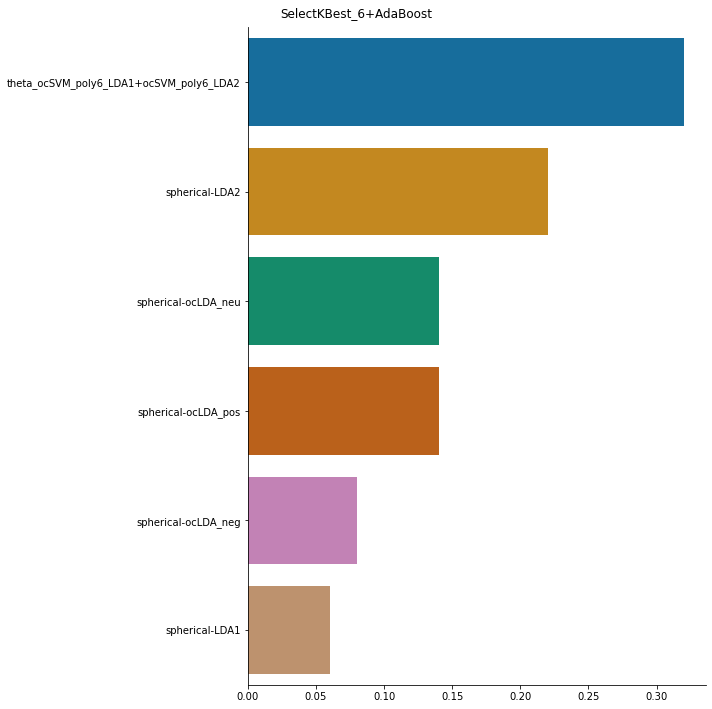

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(


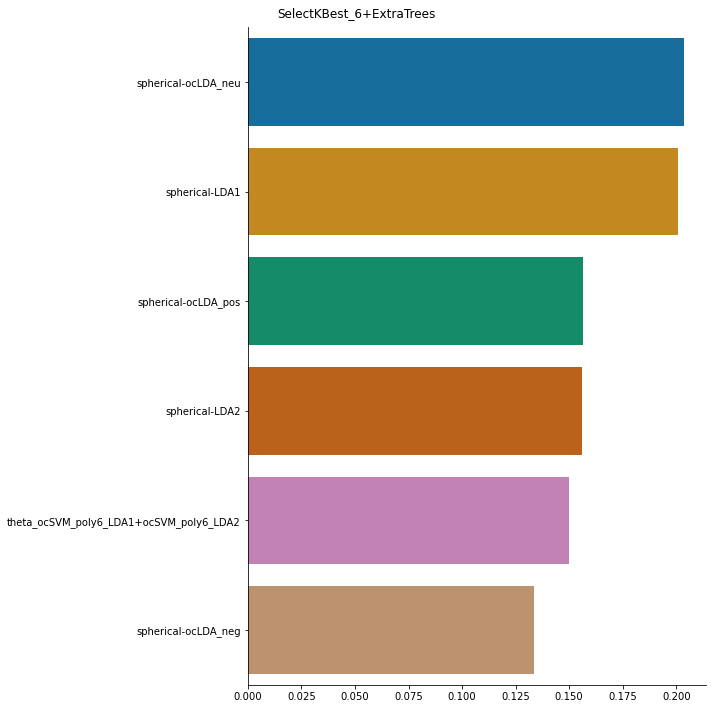

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


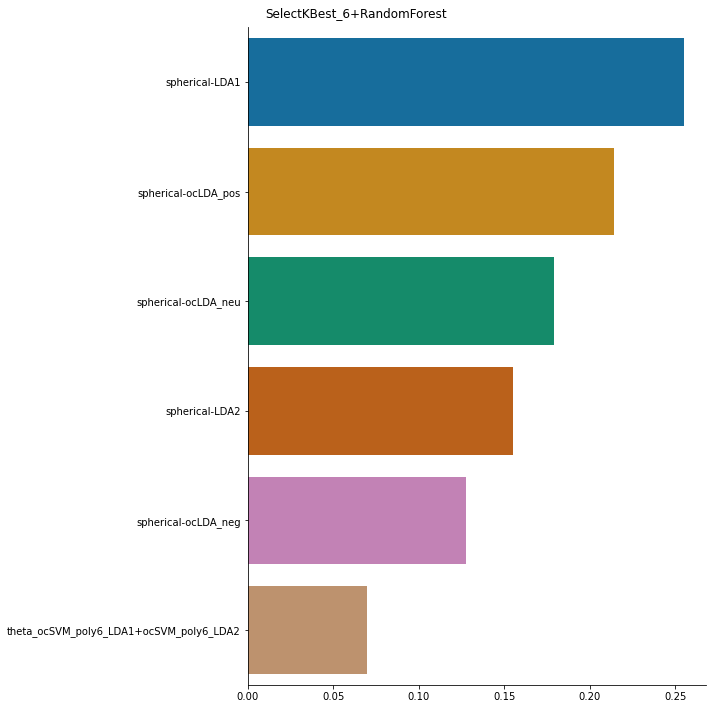

GaussianNB oob score changed by 0.1849 to 0.8818
extra trees oob score changed by -0.0176 to 0.8788
random forest oob score changed by -0.0445 to 0.8829

SelectKBest_6+AdaBoost
accuracy: 0.8562
roc_auc_ovo: 0.9036
log_loss: 0.9957
SelectKBest_6+ExtraTrees
accuracy: 0.8924
roc_auc_ovo: 0.9837
log_loss: 0.2572


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


SelectKBest_6+RandomForest
accuracy: 0.9390
roc_auc_ovo: 0.9952
log_loss: 0.1611
SelectKBest_6+GaussianNB
accuracy: 0.8818
roc_auc_ovo: 0.9714
log_loss: 0.6362

with feature selection by SelectKBest_6...
AdaBoost's accuracy changed by 0.0490 from 0.8072 to 0.8562
AdaBoost's roc_auc_ovo changed by -0.0026 from 0.9061 to 0.9036
AdaBoost's log_loss changed by -0.0146 from 1.0102 to 0.9957
ExtraTrees's accuracy changed by -0.0326 from 0.9250 to 0.8924
ExtraTrees's roc_auc_ovo changed by -0.0084 from 0.9921 to 0.9837
ExtraTrees's log_loss changed by 0.0155 from 0.2417 to 0.2572
RandomForest's accuracy changed by -0.0485 from 0.9874 to 0.9390
RandomForest's roc_auc_ovo changed by -0.0045 from 0.9997 to 0.9952
RandomForest's log_loss changed by 0.0756 from 0.0855 to 0.1611
GaussianNB's accuracy changed by 0.1846 from 0.6972 to 0.8818
GaussianNB's roc_auc_ovo changed by 0.0891 from 0.8823 to 0.9714
GaussianNB's log_loss changed by -1.0130 from 1.6493 to 0.6362

selecting with SelectKBest_7


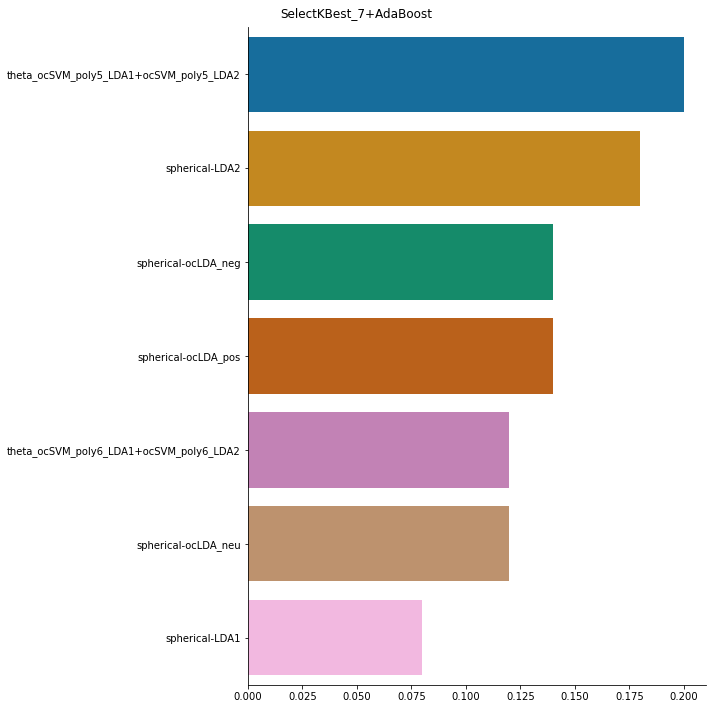

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(


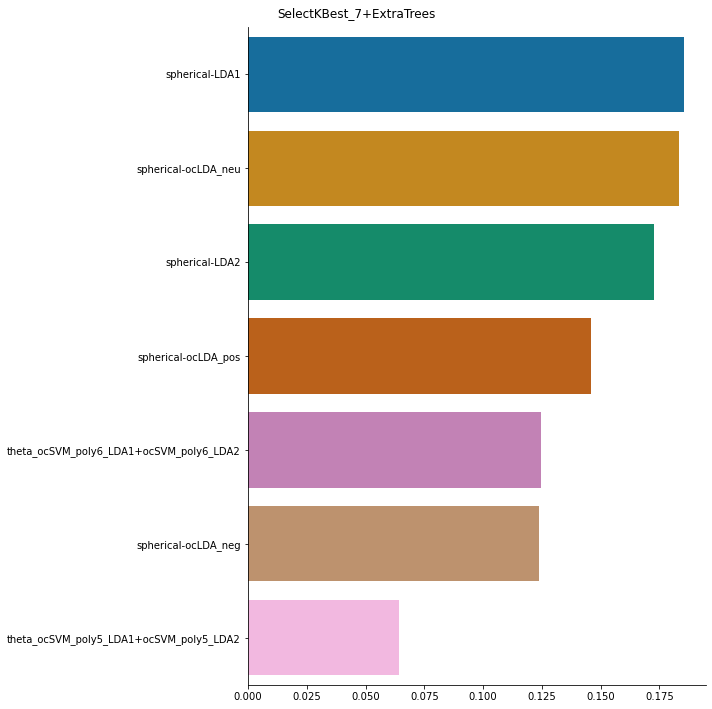

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


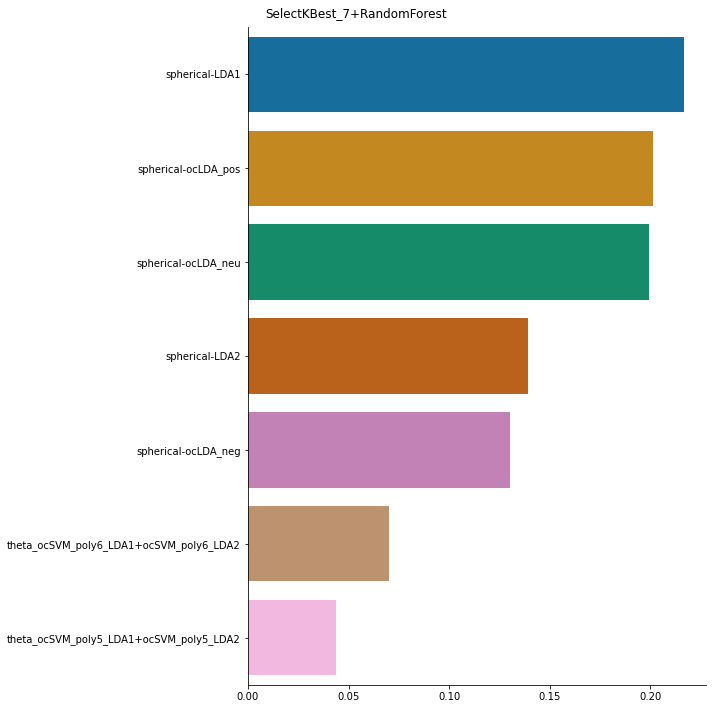

GaussianNB oob score changed by 0.1802 to 0.8771
extra trees oob score changed by -0.0163 to 0.8801
random forest oob score changed by -0.0383 to 0.8891

SelectKBest_7+AdaBoost
accuracy: 0.8501
roc_auc_ovo: 0.9355
log_loss: 0.9601
SelectKBest_7+ExtraTrees
accuracy: 0.8925
roc_auc_ovo: 0.9840
log_loss: 0.2577


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


SelectKBest_7+RandomForest
accuracy: 0.9466
roc_auc_ovo: 0.9962
log_loss: 0.1500
SelectKBest_7+GaussianNB
accuracy: 0.8771
roc_auc_ovo: 0.9703
log_loss: 0.6826

with feature selection by SelectKBest_7...
AdaBoost's accuracy changed by 0.0430 from 0.8072 to 0.8501
AdaBoost's roc_auc_ovo changed by 0.0294 from 0.9061 to 0.9355
AdaBoost's log_loss changed by -0.0502 from 1.0102 to 0.9601
ExtraTrees's accuracy changed by -0.0326 from 0.9250 to 0.8925
ExtraTrees's roc_auc_ovo changed by -0.0081 from 0.9921 to 0.9840
ExtraTrees's log_loss changed by 0.0160 from 0.2417 to 0.2577
RandomForest's accuracy changed by -0.0408 from 0.9874 to 0.9466
RandomForest's roc_auc_ovo changed by -0.0035 from 0.9997 to 0.9962
RandomForest's log_loss changed by 0.0645 from 0.0855 to 0.1500
GaussianNB's accuracy changed by 0.1799 from 0.6972 to 0.8771
GaussianNB's roc_auc_ovo changed by 0.0879 from 0.8823 to 0.9703
GaussianNB's log_loss changed by -0.9667 from 1.6493 to 0.6826

selecting with SelectKBest_8


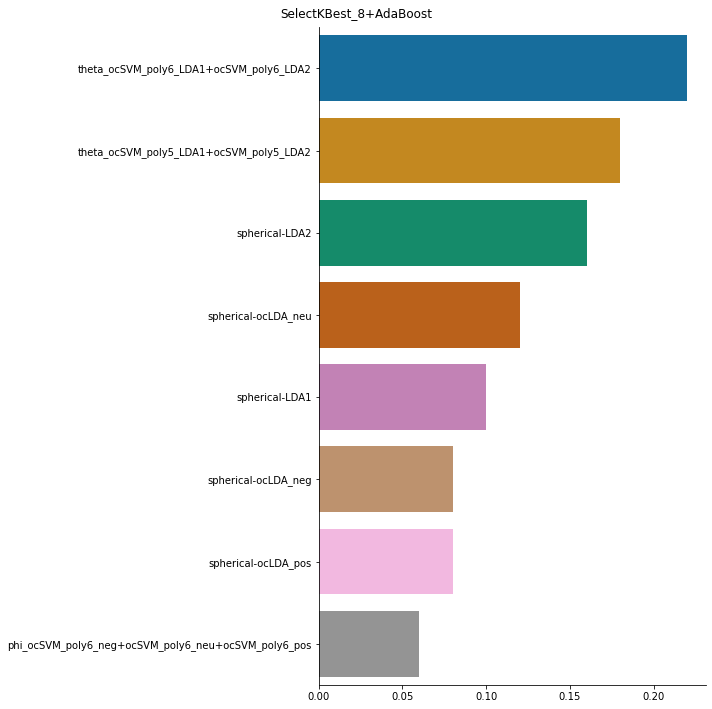

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(


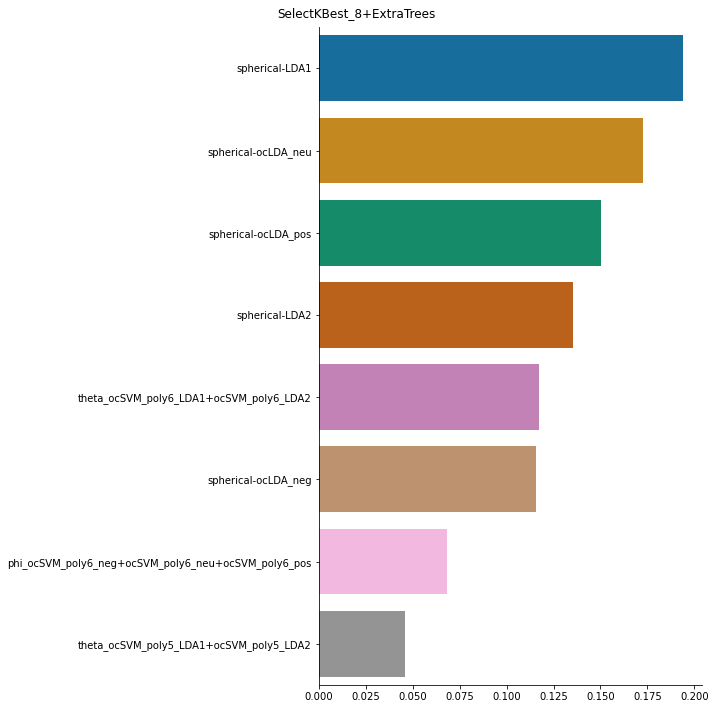

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


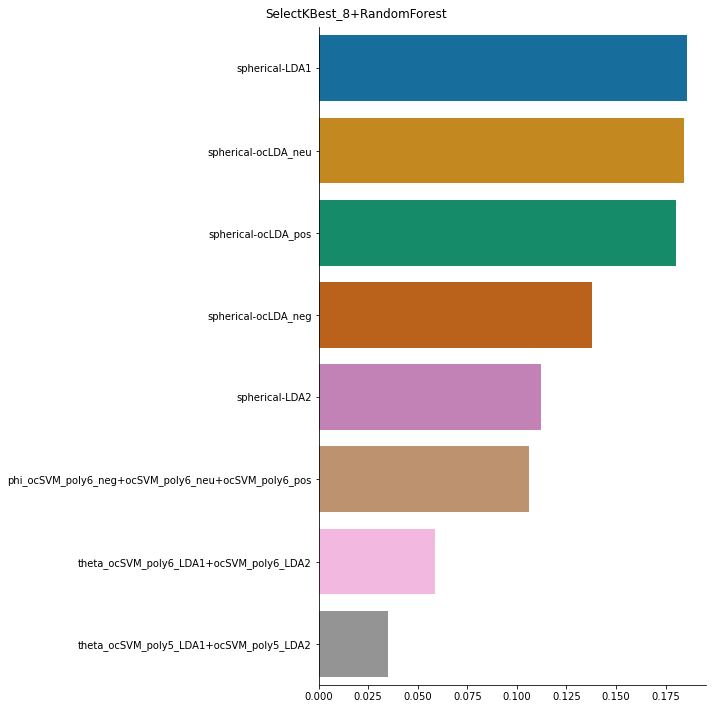

GaussianNB oob score changed by 0.1853 to 0.8821
extra trees oob score changed by -0.0144 to 0.8820
random forest oob score changed by -0.0318 to 0.8957

SelectKBest_8+AdaBoost
accuracy: 0.8347
roc_auc_ovo: 0.9239
log_loss: 0.9852
SelectKBest_8+ExtraTrees
accuracy: 0.8930
roc_auc_ovo: 0.9840
log_loss: 0.2595


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


SelectKBest_8+RandomForest
accuracy: 0.9524
roc_auc_ovo: 0.9968
log_loss: 0.1429
SelectKBest_8+GaussianNB
accuracy: 0.8822
roc_auc_ovo: 0.9713
log_loss: 0.6998

with feature selection by SelectKBest_8...
AdaBoost's accuracy changed by 0.0275 from 0.8072 to 0.8347
AdaBoost's roc_auc_ovo changed by 0.0178 from 0.9061 to 0.9239
AdaBoost's log_loss changed by -0.0250 from 1.0102 to 0.9852
ExtraTrees's accuracy changed by -0.0320 from 0.9250 to 0.8930
ExtraTrees's roc_auc_ovo changed by -0.0081 from 0.9921 to 0.9840
ExtraTrees's log_loss changed by 0.0179 from 0.2417 to 0.2595
RandomForest's accuracy changed by -0.0351 from 0.9874 to 0.9524
RandomForest's roc_auc_ovo changed by -0.0029 from 0.9997 to 0.9968
RandomForest's log_loss changed by 0.0573 from 0.0855 to 0.1429
GaussianNB's accuracy changed by 0.1850 from 0.6972 to 0.8822
GaussianNB's roc_auc_ovo changed by 0.0890 from 0.8823 to 0.9713
GaussianNB's log_loss changed by -0.9495 from 1.6493 to 0.6998

selecting with SelectKBest_9


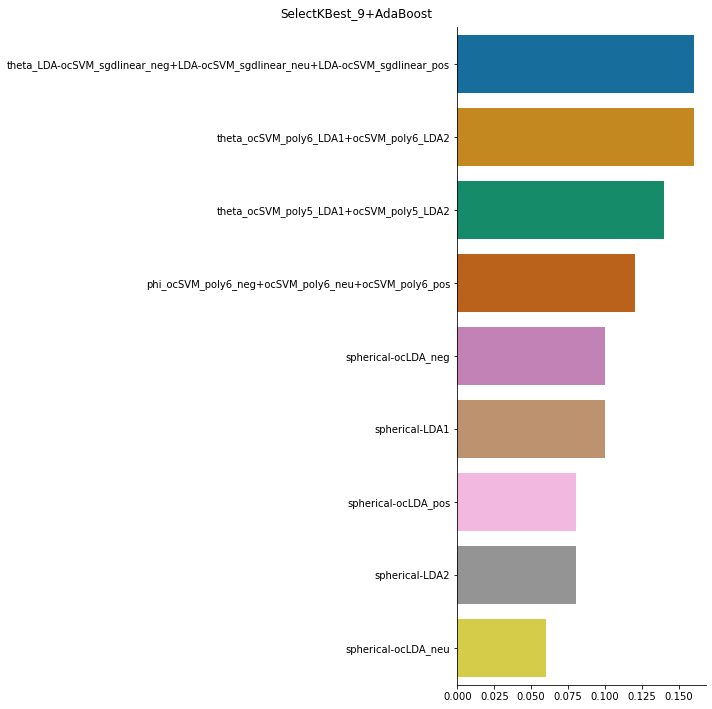

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(


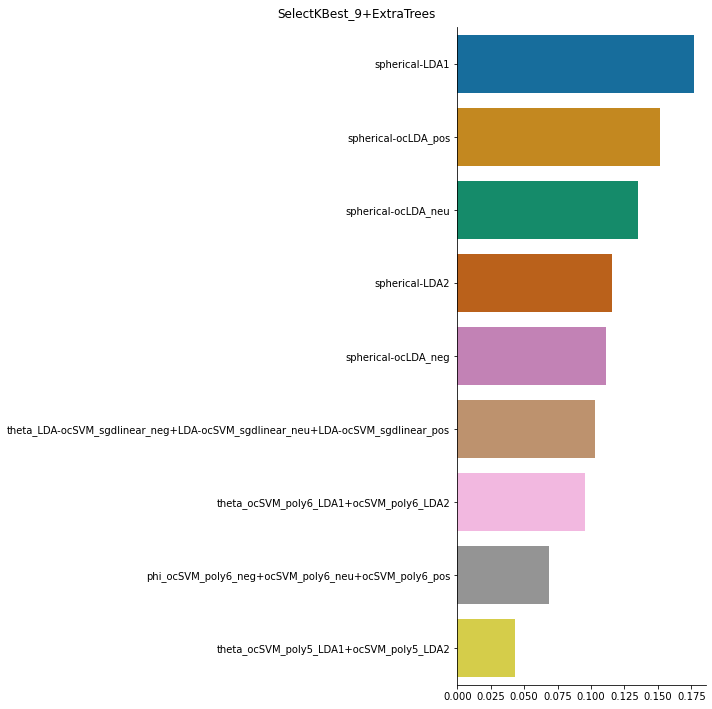

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


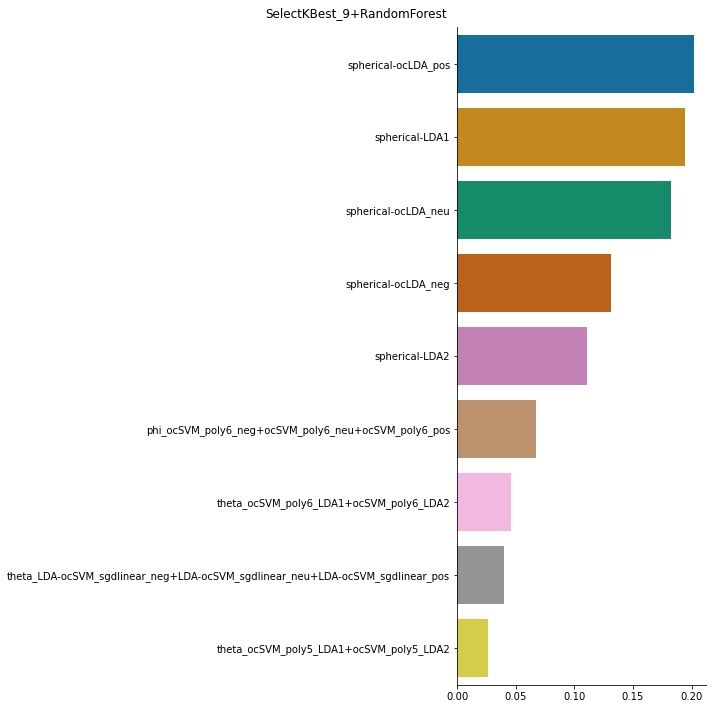

GaussianNB oob score changed by 0.1782 to 0.8750
extra trees oob score changed by -0.0065 to 0.8899
random forest oob score changed by -0.0230 to 0.9045

SelectKBest_9+AdaBoost
accuracy: 0.8513
roc_auc_ovo: 0.9259
log_loss: 1.0126
SelectKBest_9+ExtraTrees
accuracy: 0.9067
roc_auc_ovo: 0.9873
log_loss: 0.2324


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


SelectKBest_9+RandomForest
accuracy: 0.9591
roc_auc_ovo: 0.9976
log_loss: 0.1268
SelectKBest_9+GaussianNB
accuracy: 0.8750
roc_auc_ovo: 0.9698
log_loss: 0.7933

with feature selection by SelectKBest_9...
AdaBoost's accuracy changed by 0.0441 from 0.8072 to 0.8513
AdaBoost's roc_auc_ovo changed by 0.0198 from 0.9061 to 0.9259
AdaBoost's log_loss changed by 0.0024 from 1.0102 to 1.0126
ExtraTrees's accuracy changed by -0.0183 from 0.9250 to 0.9067
ExtraTrees's roc_auc_ovo changed by -0.0048 from 0.9921 to 0.9873
ExtraTrees's log_loss changed by -0.0093 from 0.2417 to 0.2324
RandomForest's accuracy changed by -0.0283 from 0.9874 to 0.9591
RandomForest's roc_auc_ovo changed by -0.0021 from 0.9997 to 0.9976
RandomForest's log_loss changed by 0.0413 from 0.0855 to 0.1268
GaussianNB's accuracy changed by 0.1778 from 0.6972 to 0.8750
GaussianNB's roc_auc_ovo changed by 0.0875 from 0.8823 to 0.9698
GaussianNB's log_loss changed by -0.8560 from 1.6493 to 0.7933

selecting with SelectKBest_10


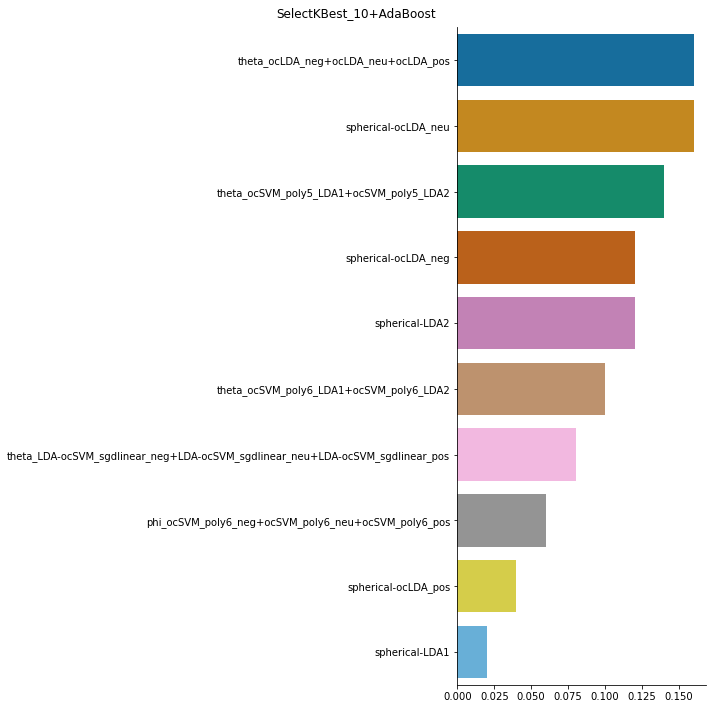

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(


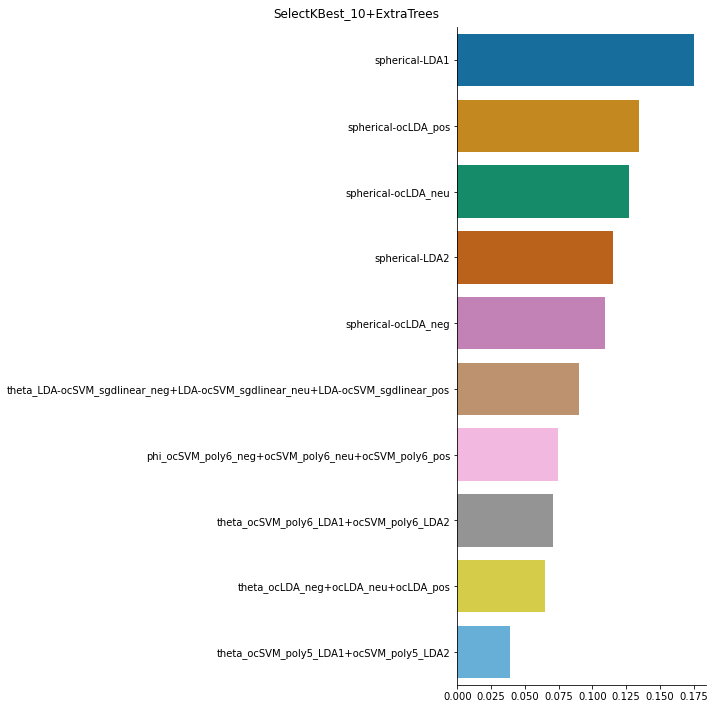

C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


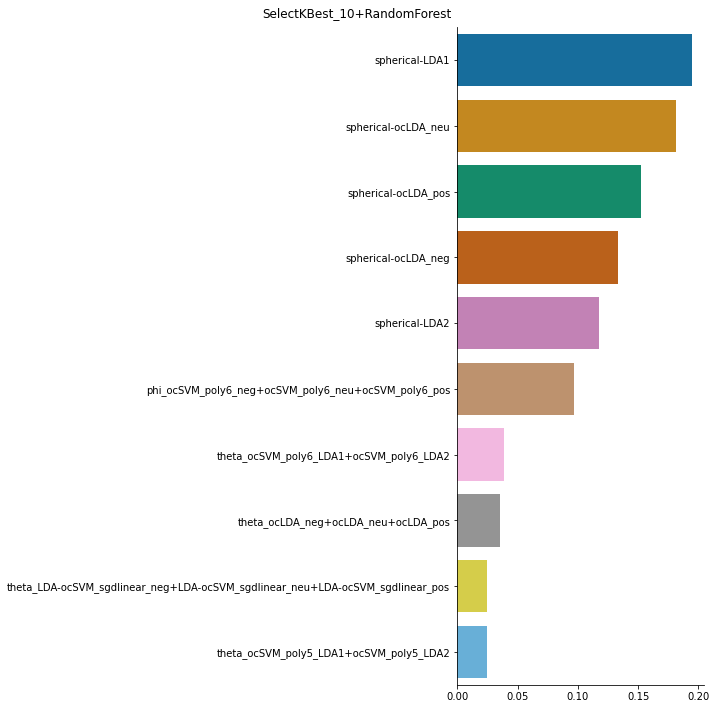

GaussianNB oob score changed by 0.1696 to 0.8664
extra trees oob score changed by -0.0030 to 0.8935
random forest oob score changed by -0.0226 to 0.9048

SelectKBest_10+AdaBoost
accuracy: 0.8623
roc_auc_ovo: 0.9527
log_loss: 0.9770
SelectKBest_10+ExtraTrees
accuracy: 0.9079
roc_auc_ovo: 0.9876
log_loss: 0.2318


C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\michen\miniconda3\envs\capstone_pyspark_38\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


SelectKBest_10+RandomForest
accuracy: 0.9604
roc_auc_ovo: 0.9977
log_loss: 0.1237
SelectKBest_10+GaussianNB
accuracy: 0.8665
roc_auc_ovo: 0.9682
log_loss: 0.9078

with feature selection by SelectKBest_10...
AdaBoost's accuracy changed by 0.0551 from 0.8072 to 0.8623
AdaBoost's roc_auc_ovo changed by 0.0465 from 0.9061 to 0.9527
AdaBoost's log_loss changed by -0.0333 from 1.0102 to 0.9770
ExtraTrees's accuracy changed by -0.0172 from 0.9250 to 0.9079
ExtraTrees's roc_auc_ovo changed by -0.0045 from 0.9921 to 0.9876
ExtraTrees's log_loss changed by -0.0098 from 0.2417 to 0.2318
RandomForest's accuracy changed by -0.0270 from 0.9874 to 0.9604
RandomForest's roc_auc_ovo changed by -0.0020 from 0.9997 to 0.9977
RandomForest's log_loss changed by 0.0381 from 0.0855 to 0.1237
GaussianNB's accuracy changed by 0.1693 from 0.6972 to 0.8665
GaussianNB's roc_auc_ovo changed by 0.0858 from 0.8823 to 0.9682
GaussianNB's log_loss changed by -0.7415 from 1.6493 to 0.9078

time: 15min 48s


In [18]:
data = load_data(unscaled=True)
fitted_trees = fit_trees(data, y_true)
selectors = {
    f"SelectKBest_{k}": SelectKBest(score_func=mutual_info_classif, k=k)
    for k in range(1, 11)
}
for selector_estimator, selector in selectors.items():
    print(f"selecting with {selector_estimator}")

    data_ = pd.DataFrame(
        selector.fit_transform(data, y_true),
        columns=selector.get_feature_names_out(data.columns),
    )
    fitted_models: Dict[str, BaseEstimator] = {}

    for ensemble_name, fitted_tree in deepcopy(fitted_trees).items():
        fitted_models[
            f"{selector_estimator}+{ensemble_name}"
        ] = fitted_tree.fit(  # re-fit
            data_, y_true
        )
        plot_importances(
            fitted_tree, fig_height=10, title=f"{selector_estimator}+{ensemble_name}"
        )
    fitted_models[f"{selector_estimator}+GaussianNB"] = make_gnb().fit(data_, y_true)
    print(
        f"GaussianNB oob score changed by {(_ := fitted_models[f'{selector_estimator}+GaussianNB'].oob_score_) - oob_gnb:.4f} to {_:.4f}"
    )
    print(
        f"extra trees oob score changed by {(_ := fitted_models[f'{selector_estimator}+ExtraTrees'].oob_score_) - oob_extra:.4f} to {_:.4f}"
    )
    print(
        f"random forest oob score changed by {(_ := fitted_models[f'{selector_estimator}+RandomForest'].oob_score_) - oob_rf:.4f} to {_:.4f}"
    )
    print()

    scores_after: Dict[str, Dict[str, float]] = {
        k: score_model(v, k, data=data_) for k, v in fitted_models.items()
    }

    print(f"\nwith feature selection by {selector_estimator}...")
    for after_model, after_score_dict in scores_before.items():
        after_scores: Dict[str, float] = scores_after[
            f"{selector_estimator}+{after_model}"
        ]
        before_scores: Dict[str, float] = scores_before[after_model]
        base_model = after_model.split("+")[-1]
        for scorer, score in after_scores.items():
            print(
                f"{base_model}'s {scorer} changed by {(after := after_scores[scorer]) - (before := before_scores[scorer]):.4f} from {before:.4f} to {after:.4f}"
            )
    print()

# Discussion

New result with unscaled! 

GaussianNB oob score changed by 0.1891 to 0.8859 with rf select (8 features)
* spherical-LDA1&2
* spherical-ocLDA_val x3
* phi_ocSVM_poly6_valx3
* theta_ocSVM_poly6_LDA1&2
* ocSVM_poly6_LDA1

My hunch is that the RF will be overfit when judged by the holdout.

The top 5 spherical LDA features work best for GaussianNB. Using just the two big spherical LDAs might be even better.

The OOB performance of the ensemble models, particularly RF, is really good on the full set. It shouldn't be too costly to train two prototypes: one with a GaussianNB and the other with RandomForest. Note that there is speaker leakage when using OOBE rather than the custom predetermined 5-fold CV.

Next steps:
* brief hyperparameter tuning using OOBE rather than CV
* train prototypes
* preproocess and evaluate hold-out data

There are so many more possibilities for feature engineering. LDA components of information distilled by other classifiers are some of the best features. LDA components could be extracted from all per-class features grouped by valence. LDA components of non-sphericals or just the LOF features could be good too.

It's important to be disciplined now and focus on deployment. Although there are numerous points of interest where tweaking is likely to yield better results, we are sticking with the feature engineering pathway we already established.

Upstream augmentation of the raw audio would probably be helpful as would resampling.

In [19]:
print(f"Time elapsed since notebook_begin_time: {time() - notebook_begin_time} s")
_ = gc_collect()

Time elapsed since notebook_begin_time: 1618.8349888324738 s
time: 131 ms


[^top](#Contents)